In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import npc_lims
# from npc_sessions import DynamicRoutingSession
from dynamic_routing_analysis import spike_utils
from dynamic_routing_analysis import data_utils
import lazynwb

import os
import pickle
import upath

%load_ext autoreload
%autoreload 2
# %matplotlib widget

In [4]:
# session_id='742903_2024-10-22' #good DR
session_id="664851_2023-11-13" #mediocre DR
# session_id="670180_2023-07-27" #templeton

session_info=npc_lims.get_session_info(session_id)
trials=data_utils.load_trials_or_units(session_info, 'trials', version='0.0.272')
units=data_utils.load_trials_or_units(session_info, 'units', version='0.0.272')

664851_2023-11-13 cached trials loaded
664851_2023-11-13 cached units loaded


In [5]:
vis_rf_trials=pd.read_parquet(
    npc_lims.get_cache_path('vis_rf_mapping',session_id,version='0.0.272')
)

aud_rf_trials=pd.read_parquet(
    npc_lims.get_cache_path('aud_rf_mapping',session_id,version='0.0.272')
)


In [6]:
path = 's3://aind-scratch-data/dynamic-routing/cache/nwb/v0.0.272/{session_id}.nwb'
internal_path = 'processing/behavior/rewards'
rewards = lazynwb.get_df(path.format(session_id=session_id), internal_path, as_polars=False)

In [7]:
rewards

,timestamps,_nwb_path,_table_path,_table_index
0,2593.83693,s3://aind-scratch-data/dynamic-routing/cache/n...,processing/behavior/rewards,0
1,2684.12920,s3://aind-scratch-data/dynamic-routing/cache/n...,processing/behavior/rewards,1
2,2774.43823,s3://aind-scratch-data/dynamic-routing/cache/n...,processing/behavior/rewards,2
3,2864.73060,s3://aind-scratch-data/dynamic-routing/cache/n...,processing/behavior/rewards,3
4,2955.22310,s3://aind-scratch-data/dynamic-routing/cache/n...,processing/behavior/rewards,4
...,...,...,...,...
144,6950.07108,s3://aind-scratch-data/dynamic-routing/cache/n...,processing/behavior/rewards,144
145,7040.58021,s3://aind-scratch-data/dynamic-routing/cache/n...,processing/behavior/rewards,145
146,7131.08945,s3://aind-scratch-data/dynamic-routing/cache/n...,processing/behavior/rewards,146
147,7221.59857,s3://aind-scratch-data/dynamic-routing/cache/n...,processing/behavior/rewards,147


In [8]:
# units_filtered['electrode_group_name']#.columns#['peak_channel']
trials.columns

Index(['start_time', 'stop_time', 'quiescent_start_time',
       'quiescent_stop_time', 'stim_start_time', 'stim_stop_time',
       'response_window_start_time', 'response_window_stop_time',
       'task_control_response_time', 'response_time', 'reward_time',
       'post_response_window_start_time', 'post_response_window_stop_time',
       'stim_name', 'block_index', 'rewarded_modality', 'trial_index',
       'trial_index_in_block', 'repeat_index', 'is_response', 'is_correct',
       'is_incorrect', 'is_hit', 'is_false_alarm', 'is_correct_reject',
       'is_miss', 'is_go', 'is_nogo', 'is_rewarded', 'is_noncontingent_reward',
       'is_contingent_reward', 'is_reward_scheduled', 'is_instruction',
       'is_aud_stim', 'is_vis_stim', 'is_catch', 'is_target', 'is_aud_target',
       'is_vis_target', 'is_nontarget', 'is_aud_nontarget', 'is_vis_nontarget',
       'is_vis_rewarded', 'is_aud_rewarded', 'is_block_switch', 'is_repeat',
       'is_opto', 'is_task_control_correct', 'session_idx

In [9]:
#make data array

units_filtered = units.query(
    'presence_ratio>=0.7 and \
    isi_violations_ratio<=0.5 and \
    amplitude_cutoff<=0.1 and \
    activity_drift<=0.1 and \
    firing_rate>=0.5 and \
    ~structure.isna() and ~location.isna()'
    ).sort_values(['electrode_group_name', 'peak_channel', 'unit_id'])

time_before = 0.5
time_after = 0.01
binsize = 0.5
trial_da = spike_utils.make_neuron_time_trials_tensor(units_filtered, trials, time_before, time_after, binsize)

In [10]:
trial_da

<xarray.DataArray (unit_id: 989, time: 1, trials: 524)>
array([[[ 0.,  0.,  0., ...,  0.,  0.,  2.]],

       [[ 0.,  4.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  2., ...,  0.,  0.,  4.]],

       ...,

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[10., 24., 46., ...,  4., 26., 20.]],

       [[14.,  8., 40., ...,  4.,  6., 16.]]])
Coordinates:
  * unit_id  (unit_id) object '664851_2023-11-13_A-281' ... '664851_2023-11-1...
  * time     (time) float64 -0.25
  * trials   (trials) int64 0 1 2 3 4 5 6 7 ... 516 517 518 519 520 521 522 523

In [11]:
#make rf mapping data arrays (baseline) 
### probably should combine across vis, aud for this

time_before = 0.1
time_after = 0.01
binsize=0.1
vis_rf_baseline_da= spike_utils.make_neuron_time_trials_tensor(units_filtered, vis_rf_trials, time_before, time_after, binsize)
aud_rf_baseline_da= spike_utils.make_neuron_time_trials_tensor(units_filtered, aud_rf_trials, time_before, time_after, binsize)

time_before=0
time_after=0.11
binsize=0.1
vis_rf_stim_da= spike_utils.make_neuron_time_trials_tensor(units_filtered, vis_rf_trials, time_before, time_after, binsize)
aud_rf_stim_da= spike_utils.make_neuron_time_trials_tensor(units_filtered, aud_rf_trials, time_before, time_after, binsize)

In [12]:
epochs=pd.read_parquet(npc_lims.get_cache_path(nwb_component='epochs', session_id=session_id, version='0.0.272'))
epochs

,start_time,stop_time,script_name,notes,interval_names,tags,session_idx,date,subject_id,session_id
id,,,,,,,,,,
0,105.380195,976.192980,RFMapping,,"[vis_rf_mapping_trials, aud_rf_mapping_trials]",[mapping],0,2023-11-13,664851,664851_2023-11-13
1,987.536300,1277.762610,OptoTagging,,[optotagging_trials],[optotagging],0,2023-11-13,664851,664851_2023-11-13
2,1288.421780,1891.176778,Spontaneous,,[spontaneous_trials],[spontaneous],0,2023-11-13,664851,664851_2023-11-13
3,2503.722420,3106.077027,SpontaneousRewards,,[spontaneous_rewards_trials],"[rewards, spontaneous]",0,2023-11-13,664851,664851_2023-11-13
4,3117.286355,6757.737323,DynamicRouting1,,"[trials, performance]","[task, rewards]",0,2023-11-13,664851,664851_2023-11-13
5,6769.463940,7372.469217,SpontaneousRewards,,[spontaneous_rewards_trials],"[rewards, spontaneous]",0,2023-11-13,664851,664851_2023-11-13
6,7387.231630,7677.174594,OptoTagging,,[optotagging_trials],[optotagging],0,2023-11-13,664851,664851_2023-11-13


In [13]:
epochs.query('script_name=="DynamicRouting1"').index[0]

4

Text(0, 0.5, 'Count')

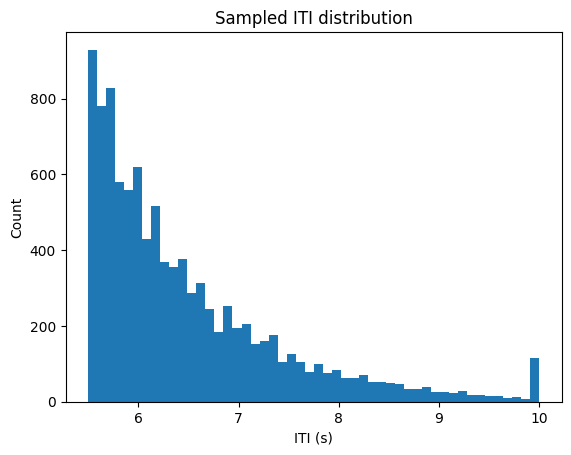

In [14]:
#generate ITIs with same statistics as the task

def generate_DR_ITI(n_samples=None,is_templeton=False):

    import random

    preStimFramesFixed = 90 # min frames between start of trial and stimulus onset
    preStimFramesVariableMean = 60 # mean of additional preStim frames drawn from exponential distribution
    preStimFramesMax = 360 # max total preStim frames
    # quiescentFrames = 90 # frames before stim onset during which licks delay stim onset
    responseWindow = [6,60]
    postResponseWindowFrames = 180

    if is_templeton:
        preStimFramesVariableMean = 30 
        preStimFramesMax = 240
        postResponseWindowFrames = 120

    if n_samples is not None:
        return [generate_DR_ITI(is_templeton=is_templeton) for _ in range(n_samples)]
    else:
        val = preStimFramesFixed + random.expovariate(1/preStimFramesVariableMean) if preStimFramesVariableMean > 1 else preStimFramesFixed + preStimFramesVariableMean
        trial_total_length = (int(min(val,preStimFramesMax)) + responseWindow[1] + postResponseWindowFrames)/60 #in seconds

        return trial_total_length

# sample_ITIs=[]
# for xx in range(10000):  # Generate 10000 samples
#     sample_ITIs.append(generate_DR_ITI())

sample_ITIs=generate_DR_ITI(n_samples=10000,is_templeton=False)

fig,ax=plt.subplots(1,1)
ax.hist(sample_ITIs, bins=50)
ax.set_title('Sampled ITI distribution')
ax.set_xlabel('ITI (s)')
ax.set_ylabel('Count')

In [15]:
#get spontaneous equivalent to trial_da - generate false trials using itis
# epochs.query('script_name.str.contains("Spontaneous")') #spont with & without rewards
# epochs.query('script_name=="Spontaneous"')

time_before = 0
time_after = 0.51
binsize = 0.5

min_ITI=5.5

spont_trials={
    'start_time':[],
    'epoch_idx':[],
    'epoch_name':[],
    'is_rewarded':[]
}

task_index=epochs.query('script_name=="DynamicRouting1"').index[0]

for rr,row in epochs.query('script_name=="Spontaneous" and id<@task_index').iterrows():
    spont_start=row['start_time']
    spont_end=row['stop_time']
    spont_duration=spont_end-spont_start
    
    sampleITIs=generate_DR_ITI(n_samples=1000,is_templeton=False)
    cum_sampleITIs=np.cumsum(sampleITIs)
    valid_starts=spont_start+cum_sampleITIs[cum_sampleITIs+spont_start<spont_end]
    is_rewarded=np.zeros(len(valid_starts),dtype=bool)

    #find rewards and align trials to them, prevent any overlapping trials
    reward_times=rewards.query('timestamps>=@spont_start and timestamps<=@spont_end')['timestamps'].to_numpy()
    if len(reward_times)>0:
        #remove any valid_starts that would overlap with reward times
        for rt in reward_times:
            incl_idx=np.abs(valid_starts-rt)>(min_ITI)
            valid_starts=valid_starts[incl_idx]
            is_rewarded= is_rewarded[incl_idx]
        #add trials aligned to rewards
        valid_starts = np.concatenate([valid_starts, reward_times])
        is_rewarded = np.concatenate([is_rewarded, np.ones(len(reward_times), dtype=bool)])

    spont_trials['start_time'].append(valid_starts)
    spont_trials['epoch_idx'].append(np.repeat(rr,len(valid_starts)))
    spont_trials['epoch_name'].append(np.repeat(row['script_name'],len(valid_starts)))
    spont_trials['is_rewarded'].append(is_rewarded)

spont_trials['start_time'] = np.concatenate(spont_trials['start_time'])
spont_trials['epoch_idx'] = np.concatenate(spont_trials['epoch_idx'])
spont_trials['epoch_name'] = np.concatenate(spont_trials['epoch_name'])
spont_trials['is_rewarded'] =  np.concatenate(spont_trials['is_rewarded'])

spont_trials_df = pd.DataFrame(spont_trials).sort_values('start_time').reset_index(drop=True)

spont_trial_da = spike_utils.make_neuron_time_trials_tensor(units_filtered, spont_trials_df, time_before, time_after, binsize, event_name='start_time')



In [16]:
spont_trials_df.query('is_rewarded==True')

,start_time,epoch_idx,epoch_name,is_rewarded


In [17]:
#make spont with rewards trials

### correlation between 1st PC across areas

In [18]:
# run pca on the data array
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(trial_da.data.reshape(trial_da.data.shape[0], -1).T)

pca = PCA()
pca.fit(scaled_data)

transformed_data = pca.transform(scaled_data)


0.17484345709985386

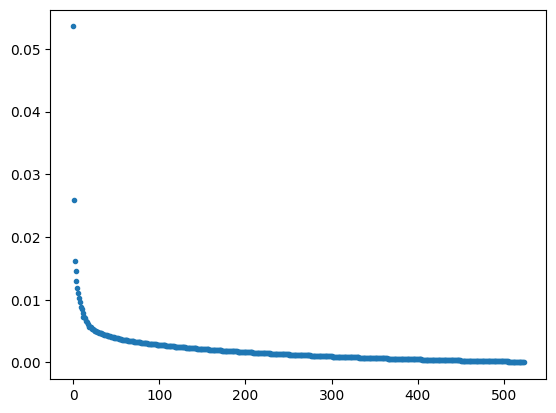

In [19]:
fig,ax=plt.subplots(1,1)
ax.plot(pca.explained_variance_ratio_,'.')
pca.explained_variance_ratio_[:10].sum()

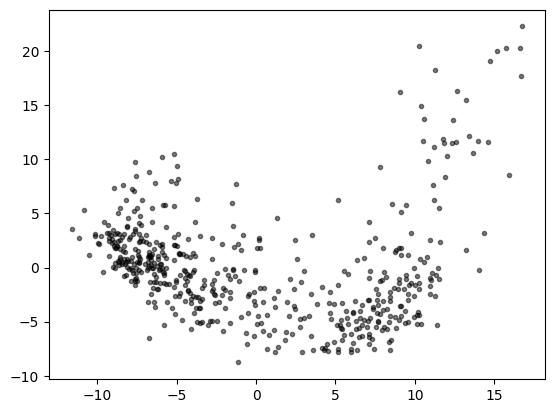

In [20]:
fig,ax=plt.subplots(1,1)
ax.plot(transformed_data[:,0],transformed_data[:,1],'k.',alpha=0.5)
# ax.plot(transformed_data[:,0:2],alpha=0.5)

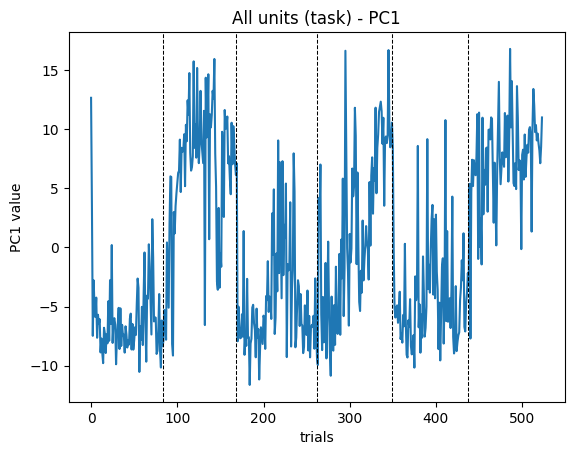

In [21]:
#all units
fig,ax=plt.subplots(1,1)
ax.plot(transformed_data[:,0])
ax.set_title('All units (task) - PC1')
ax.set_xlabel('trials')
ax.set_ylabel('PC1 value')
#plot block switches
for rr,row in trials.query('is_block_switch').iterrows():
    ax.axvline(row['trial_index']-0.5, color='k', linestyle='--', linewidth=0.75)

In [22]:
scaled_spont_data = scaler.fit_transform(spont_trial_da.data.reshape(spont_trial_da.data.shape[0], -1).T)
pca_spont = PCA()
pca_spont.fit(scaled_spont_data)
transformed_data_spont = pca_spont.transform(scaled_spont_data)
transformed_data_spont_by_task = pca.transform(scaled_spont_data)

In [23]:
pca_task_first_half = PCA()
pca_task_first_half.fit(scaled_data[:len(scaled_data)//2, :])
transformed_data_task_first_half = pca_task_first_half.transform(scaled_data[:len(scaled_data)//2, :])

pca_task_second_half = PCA()
pca_task_second_half.fit(scaled_data[len(scaled_data)//2:, :])
transformed_data_task_second_half = pca_task_second_half.transform(scaled_data[len(scaled_data)//2:, :])

pca_spont_first_half = PCA()
pca_spont_first_half.fit(scaled_spont_data[:len(scaled_spont_data)//2, :])
transformed_data_spont_first_half = pca_spont_first_half.transform(scaled_spont_data[:len(scaled_spont_data)//2, :])

pca_spont_second_half = PCA()
pca_spont_second_half.fit(scaled_spont_data[len(scaled_spont_data)//2:, :])
transformed_data_spont_second_half = pca_spont_second_half.transform(scaled_spont_data[len(scaled_spont_data)//2:, :])


In [24]:
scaled_data[:len(scaled_data)//2, :].shape
# scaled_spont_data.shape

(262, 989)

In [25]:
transformed_data_task_first_half.shape

(262, 262)

In [26]:
stats.pearsonr(pca_task_first_half.components_[0,:], pca_task_second_half.components_[0,:])

PearsonRResult(statistic=0.8308699598632754, pvalue=1.7114275505535626e-253)

In [27]:
stats.pearsonr(pca_spont_first_half.components_[0,:], pca_spont_second_half.components_[0,:])

PearsonRResult(statistic=-0.7364982762053112, pvalue=9.398593933996634e-170)

In [28]:
stats.pearsonr(pca_task_first_half.components_[0,:], pca_spont_first_half.components_[0,:])

PearsonRResult(statistic=0.08253860412159512, pvalue=0.009408190269968282)

In [29]:
stats.pearsonr(pca.components_[0,:],pca_spont.components_[0,:])

PearsonRResult(statistic=-0.005672968419823794, pvalue=0.8585804952907877)

In [30]:
# pca.components_[0,:].shape

# transformed_data_task_first_half.shape

In [225]:
from sklearn.cross_decomposition import CCA

struct1='CP'
struct2='FRP'

#get task PCs for each structure
units_in_struct1=units_filtered[units_filtered['structure']==struct1]['unit_id'].unique()
struct1_da=trial_da.sel(unit_id=units_in_struct1)
scaled_data_struct1 = scaler.fit_transform(struct1_da.data.reshape(struct1_da.data.shape[0], -1).T)
PCA_struct1 = PCA()
PCA_struct1.fit(scaled_data_struct1)
transformed_data_struct1 = PCA_struct1.transform(scaled_data_struct1)

units_in_struct2=units_filtered[units_filtered['structure']==struct2]['unit_id'].unique()
struct2_da=trial_da.sel(unit_id=units_in_struct2)
scaled_data_struct2 = scaler.fit_transform(struct2_da.data.reshape(struct2_da.data.shape[0], -1).T)
PCA_struct2 = PCA()
PCA_struct2.fit(scaled_data_struct2)
transformed_data_struct2 = PCA_struct2.transform(scaled_data_struct2)

#run cca on task activity from the two structures
cca_task = CCA(n_components=20)
cca_task.fit(transformed_data_struct1[:,:], transformed_data_struct2[:,:])
X_c_task, Y_c_task = cca_task.transform(transformed_data_struct1[:,:], transformed_data_struct2[:,:])


#get spont PCs for each structure
units_in_struct1_spont=units_filtered[units_filtered['structure']==struct1]['unit_id'].unique()
struct1_spont_da=spont_trial_da.sel(unit_id=units_in_struct1_spont)
scaled_data_struct1_spont = scaler.fit_transform(struct1_spont_da.data.reshape(struct1_spont_da.data.shape[0], -1).T)
PCA_struct1_spont = PCA()
PCA_struct1_spont.fit(scaled_data_struct1_spont)
transformed_data_struct1_spont = PCA_struct1_spont.transform(scaled_data_struct1_spont)

units_in_struct2_spont=units_filtered[units_filtered['structure']==struct2]['unit_id'].unique()
struct2_spont_da=spont_trial_da.sel(unit_id=units_in_struct2_spont)
scaled_data_struct2_spont = scaler.fit_transform(struct2_spont_da.data.reshape(struct2_spont_da.data.shape[0], -1).T)
PCA_struct2_spont = PCA()
PCA_struct2_spont.fit(scaled_data_struct2_spont)
transformed_data_struct2_spont = PCA_struct2_spont.transform(scaled_data_struct2_spont)

#run cca on spont activity from the two structures
cca_spont = CCA(n_components=20)
cca_spont.fit(transformed_data_struct1_spont[:,:], transformed_data_struct2_spont[:,:])
X_c_spont, Y_c_spont = cca_spont.transform(transformed_data_struct1_spont[:,:], transformed_data_struct2_spont[:,:])


#transform spont data into task PCA space for each structure, then run cca
transformed_data_struct1_spont_by_task = PCA_struct1.transform(scaled_data_struct1_spont)
transformed_data_struct2_spont_by_task = PCA_struct2.transform(scaled_data_struct2_spont)
cca_spont_by_task = CCA(n_components=20)
cca_spont_by_task.fit(transformed_data_struct1_spont_by_task[:,:], transformed_data_struct2_spont_by_task[:,:])
X_c_spont_by_task, Y_c_spont_by_task = cca_spont_by_task.transform(transformed_data_struct1_spont_by_task[:,:], transformed_data_struct2_spont_by_task[:,:])

#transform task data into spont PCA space for each structure, then run cca
transformed_data_struct1_task_by_spont = PCA_struct1_spont.transform(scaled_data_struct1)
transformed_data_struct2_task_by_spont = PCA_struct2_spont.transform(scaled_data_struct2)
cca_task_by_spont = CCA(n_components=20)
cca_task_by_spont.fit(transformed_data_struct1_task_by_spont[:,:], transformed_data_struct2_task_by_spont[:,:])
X_c_task_by_spont, Y_c_task_by_spont = cca_task_by_spont.transform(transformed_data_struct1_task_by_spont[:,:], transformed_data_struct2_task_by_spont[:,:])


c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\sklearn\cross_decomposition\_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


In [195]:
# cca_task.x_loadings_
# cca_task.score(transformed_data_struct1[:,:], transformed_data_struct2[:,:])
# X_c_task.shape

In [226]:
# cca_task.y_weights_
# X_c_spont.shape

canonical_correlations = {
    'task':[],
    'spont':[],
    'task_by_spont':[],
    'spont_by_task':[],
}

for i in range(X_c_task.shape[1]):
    # np.corrcoef returns a 2x2 matrix; we need the off-diagonal element (index [0, 1])
    corr = np.corrcoef(X_c_task[:, i], Y_c_task[:, i])[0, 1]
    canonical_correlations['task'].append(corr)
    
for i in range(X_c_spont.shape[1]):
    corr = np.corrcoef(X_c_spont[:, i], Y_c_spont[:, i])[0, 1]
    canonical_correlations['spont'].append(corr)

for i in range(X_c_task_by_spont.shape[1]):
    corr = np.corrcoef(X_c_task_by_spont[:, i], Y_c_task_by_spont[:, i])[0, 1]
    canonical_correlations['task_by_spont'].append(corr)

for i in range(X_c_spont_by_task.shape[1]):
    corr = np.corrcoef(X_c_spont_by_task[:, i], Y_c_spont_by_task[:, i])[0, 1]
    canonical_correlations['spont_by_task'].append(corr)

In [1]:
canonical_correlations['task_by_spont']

NameError: name 'canonical_correlations' is not defined

In [ ]:
# from sklearn.cross_decomposition import CCA

# cca_task_task = CCA(n_components=3)
# cca_task_task.fit(transformed_data_task_first_half[:,:10], transformed_data_spont_first_half[:,:10])
# X_c_task_task, Y_c_task_task = cca_task_task.transform(transformed_data_task_first_half[:,:10], transformed_data_spont_first_half[:,:10])

# cca_task_spont = CCA(n_components=10)
# cca_task_spont.fit(scaled_data, scaled_spont_data)
# X_c_task_spont, Y_c_task_spont = cca_task_spont.transform(scaled_data, scaled_spont_data)


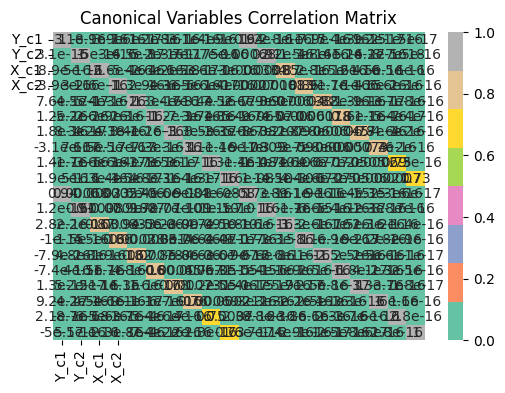

In [184]:
# cca_task_task.score(transformed_data_task_first_half, transformed_data_task_second_half)
import seaborn as sns

# Calculate the correlation matrix between canonical variables
# correlation_matrix = np.corrcoef(X_c_task.T, Y_c_task.T)
correlation_matrix = np.corrcoef(X_c_spont.T, Y_c_spont.T)


# Plot the correlation matrix as a heatmap
plt.figure(figsize=(6,4))
sns.heatmap(correlation_matrix, annot=True, cmap='Set2', 
            xticklabels=['Y_c1', 'Y_c2','X_c1', 'X_c2'], 
            yticklabels=['Y_c1', 'Y_c2','X_c1', 'X_c2'])
plt.title('Canonical Variables Correlation Matrix')
plt.show()

In [133]:
# np.corrcoef(X_c_task_task[:,1], Y_c_task_task[:,1])

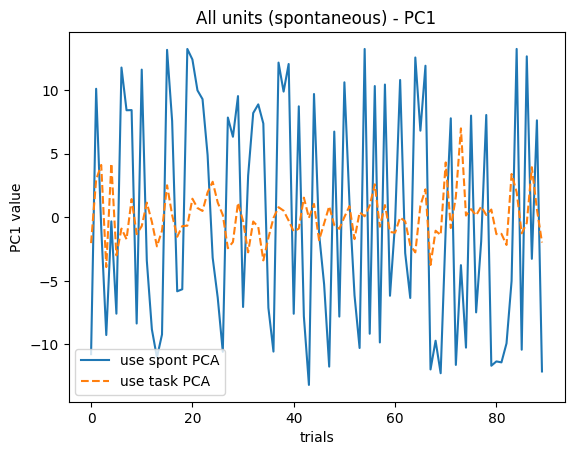

In [31]:
#all units - spontaneous activity
fig,ax=plt.subplots(1,1)
ax.plot(transformed_data_spont[:,0], label='use spont PCA')
ax.plot(transformed_data_spont_by_task[:,0], linestyle='--', label='use task PCA')
ax.set_title('All units (spontaneous) - PC1')
ax.set_xlabel('trials')
ax.set_ylabel('PC1 value')
ax.legend()

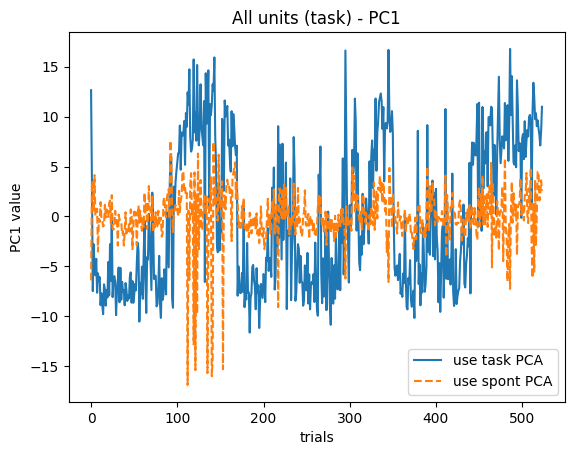

In [32]:
transformed_data = pca.transform(scaled_data)
transformed_data_by_spont = pca_spont.transform(scaled_data)
fig,ax=plt.subplots(1,1)
ax.plot(transformed_data[:,0], label='use task PCA')
ax.plot(transformed_data_by_spont[:,0], linestyle='--', label='use spont PCA')
ax.set_title('All units (task) - PC1')
ax.set_xlabel('trials')
ax.set_ylabel('PC1 value')
ax.legend()

In [ ]:
# from sklearn.cross_decomposition import CCA

# scaled_task_data = scaler.fit_transform(trial_da.data.reshape(trial_da.data.shape[0], -1).T)
# scaled_spont_data = scaler.fit_transform(spont_trial_da.data.reshape(spont_trial_da.data.shape[0], -1).T)

# cca = CCA(n_components=10)
# cca.fit(scaled_task_data, scaled_spont_data)
# X_c, Y_c = cca.transform(scaled_task_data, scaled_spont_data)
# cca.score(scaled_task_data, scaled_spont_data)

In [33]:
#do PCA per structure, then correlate PC1s across structures
structures=units_filtered['structure'].unique()
structure_pca_results={}
structure_pca_results_spont={}
structure_pca_results_spont_by_task={}
structure_pca_results_task_by_spont={}
for structure in structures:
    units_in_structure=units_filtered[units_filtered['structure']==structure]['unit_id'].unique()
    if len(units_in_structure)<10:
        continue
    
    structure_da=trial_da.sel(unit_id=units_in_structure)
    scaled_data = scaler.fit_transform(structure_da.data.reshape(structure_da.data.shape[0], -1).T)

    pca = PCA()
    pca.fit(scaled_data)
    transformed_data_structure = pca.transform(scaled_data)

    structure_pca_results[structure]=transformed_data_structure

    # Perform PCA on spontaneous activity
    spont_structure_da=spont_trial_da.sel(unit_id=units_in_structure)
    scaled_data_spont = scaler.fit_transform(spont_structure_da.data.reshape(spont_structure_da.data.shape[0], -1).T)
    
    pca_spont = PCA()
    pca_spont.fit(scaled_data_spont)
    transformed_data_structure_spont = pca_spont.transform(scaled_data_spont)

    structure_pca_results_spont[structure]=transformed_data_structure_spont

    # Use task PCA to transform spont activity
    transformed_data_spont_task_pca = pca.transform(scaled_data_spont)
    structure_pca_results_spont_by_task[structure] = transformed_data_spont_task_pca

    # Use spont PCA to transform task activity
    transformed_data_task_spont_pca = pca_spont.transform(scaled_data)
    structure_pca_results_task_by_spont[structure] = transformed_data_task_spont_pca

Text(0, 0.5, 'PC1 value')

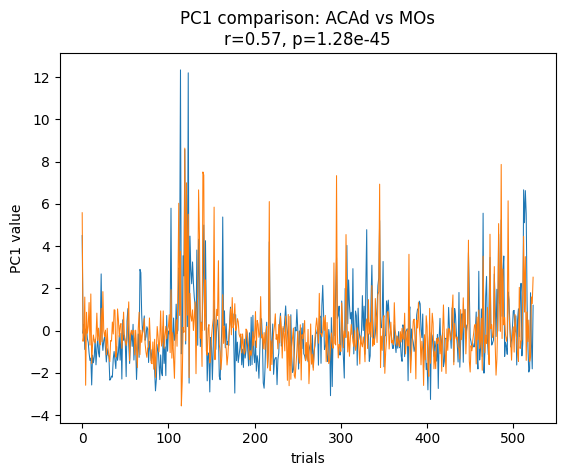

In [41]:
sel_structure_1='ACAd'
sel_structure_2='MOs'
fig,ax=plt.subplots(1,1)

# structure_pca_results, structure_pca_results_spont, structure_pca_results_spont_by_task, structure_pca_results_task_by_spont

sel_results=structure_pca_results_task_by_spont

structure_1_PC1=sel_results[sel_structure_1][:,0]
structure_2_PC1=sel_results[sel_structure_2][:,0]

r,p=stats.pearsonr(structure_1_PC1, structure_2_PC1)

ax.plot(structure_1_PC1, label=sel_structure_1, linewidth=0.75)
ax.plot(structure_2_PC1, label=sel_structure_2, linewidth=0.75)
ax.set_title(f'PC1 comparison: {sel_structure_1} vs {sel_structure_2}\nr={r:.2f}, p={p:.2e}')
ax.set_xlabel('trials')
ax.set_ylabel('PC1 value')

In [ ]:
#get correlation between every pair of structures
structure_list=np.sort(list(structure_pca_results.keys()))
n_structures=len(structure_list)
task_corr_all_pairs=np.zeros((n_structures, n_structures))
spont_corr_all_pairs=np.zeros((n_structures, n_structures))
spont_by_task_corr_all_pairs=np.zeros((n_structures, n_structures))
task_by_spont_corr_all_pairs=np.zeros((n_structures, n_structures))
for i in range(n_structures):
    for j in range(n_structures):
        if i==j:
            task_corr_all_pairs[i,j]=np.nan
            spont_corr_all_pairs[i,j]=np.nan
            continue
        structure_i_PC1=structure_pca_results[structure_list[i]][:,0]
        structure_j_PC1=structure_pca_results[structure_list[j]][:,0]
        r_task,p_task=stats.pearsonr(structure_i_PC1, structure_j_PC1)
        task_corr_all_pairs[i,j]=r_task
        # compute spontaneous correlation
        structure_i_PC1=structure_pca_results_spont[structure_list[i]][:,0]
        structure_j_PC1=structure_pca_results_spont[structure_list[j]][:,0]
        r_spont,p_spont=stats.pearsonr(structure_i_PC1, structure_j_PC1)
        spont_corr_all_pairs[i,j]=r_spont
        # compute spont by task correlation
        structure_i_PC1=structure_pca_results_spont_by_task[structure_list[i]][:,0]
        structure_j_PC1=structure_pca_results_spont_by_task[structure_list[j]][:,0]
        r_spont_by_task,p_spont_by_task=stats.pearsonr(structure_i_PC1, structure_j_PC1)
        spont_by_task_corr_all_pairs[i,j]=r_spont_by_task
        # compute task by spont correlation
        structure_i_PC1=structure_pca_results_task_by_spont[structure_list[i]][:,0]
        structure_j_PC1=structure_pca_results_task_by_spont[structure_list[j]][:,0]
        r_task_by_spont,p_task_by_spont=stats.pearsonr(structure_i_PC1, structure_j_PC1)
        task_by_spont_corr_all_pairs[i,j]=r_task_by_spont



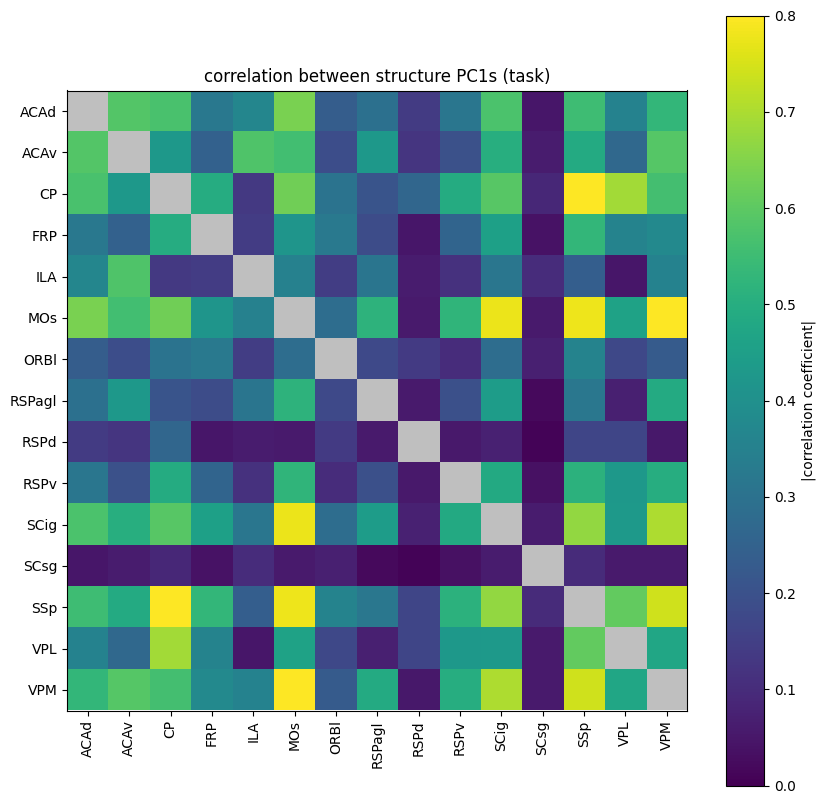

In [210]:
input_matrix=np.abs(task_corr_all_pairs)

import matplotlib
masked_array = np.ma.array(input_matrix, mask=np.isnan(input_matrix))
cmap = matplotlib.cm.viridis
cmap.set_bad('grey',0.5)

fig,ax=plt.subplots(1,1,figsize=(10,10))

im=ax.imshow(input_matrix, cmap=cmap, vmin=0, vmax=0.8)

ax.set_xticks(np.arange(n_structures))
ax.set_xticklabels(structure_list, rotation=90)
ax.set_yticks(np.arange(n_structures))
ax.set_yticklabels(structure_list)
ax.set_title('correlation between structure PC1s (task)')

fig.colorbar(im, ax=ax, label='|correlation coefficient|')

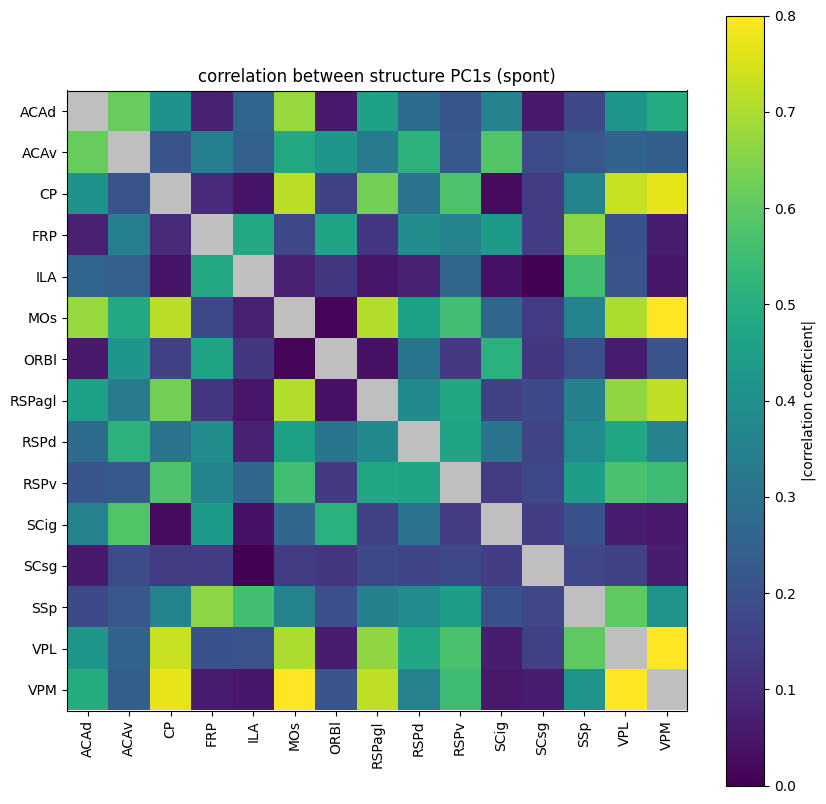

In [211]:
input_matrix=np.abs(spont_corr_all_pairs)

import matplotlib
masked_array = np.ma.array(input_matrix, mask=np.isnan(input_matrix))
cmap = matplotlib.cm.viridis
cmap.set_bad('grey',0.5)

fig,ax=plt.subplots(1,1,figsize=(10,10))

im=ax.imshow(input_matrix, cmap=cmap, vmin=0, vmax=0.8)

ax.set_xticks(np.arange(n_structures))
ax.set_xticklabels(structure_list, rotation=90)
ax.set_yticks(np.arange(n_structures))
ax.set_yticklabels(structure_list)
ax.set_title('correlation between structure PC1s (spont)')

fig.colorbar(im, ax=ax, label='|correlation coefficient|')

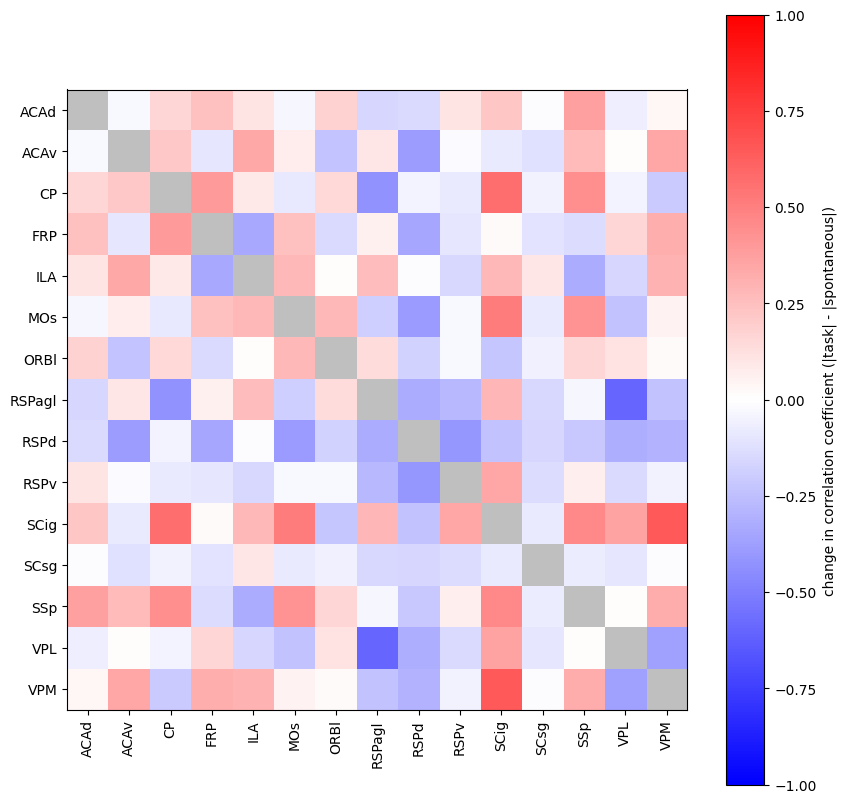

In [79]:
input_matrix=np.abs(task_corr_all_pairs)-np.abs(spont_corr_all_pairs)

import matplotlib
masked_array = np.ma.array(input_matrix, mask=np.isnan(input_matrix))
cmap = matplotlib.cm.bwr
cmap.set_bad('grey',0.5)

fig,ax=plt.subplots(1,1,figsize=(10,10))

im=ax.imshow(input_matrix, cmap=cmap, vmin=-1.0, vmax=1.0)

ax.set_xticks(np.arange(n_structures))
ax.set_xticklabels(structure_list, rotation=90)
ax.set_yticks(np.arange(n_structures))
ax.set_yticklabels(structure_list)

fig.colorbar(im, ax=ax, label='change in correlation coefficient (|task| - |spontaneous|)')

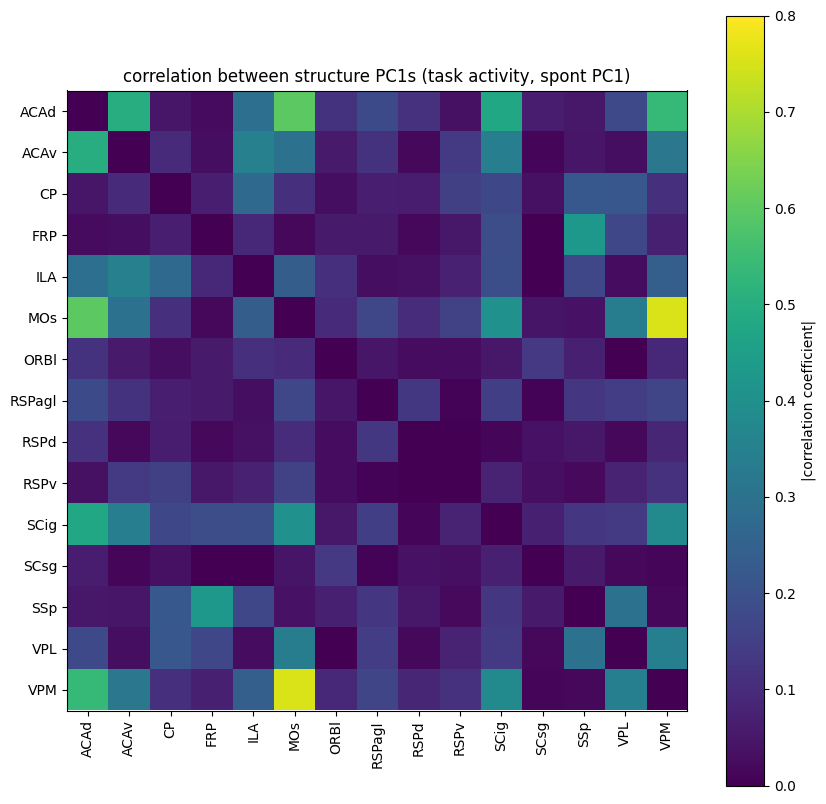

In [221]:
input_matrix=np.abs(task_by_spont_corr_all_pairs)

import matplotlib
masked_array = np.ma.array(input_matrix, mask=np.isnan(input_matrix))
cmap = matplotlib.cm.viridis
cmap.set_bad('grey',0.5)

fig,ax=plt.subplots(1,1,figsize=(10,10))

im=ax.imshow(input_matrix, cmap=cmap, vmin=0, vmax=0.8)

ax.set_xticks(np.arange(n_structures))
ax.set_xticklabels(structure_list, rotation=90)
ax.set_yticks(np.arange(n_structures))
ax.set_yticklabels(structure_list)
ax.set_title('correlation between structure PC1s (task activity, spont PC1)')

fig.colorbar(im, ax=ax, label='|correlation coefficient|')

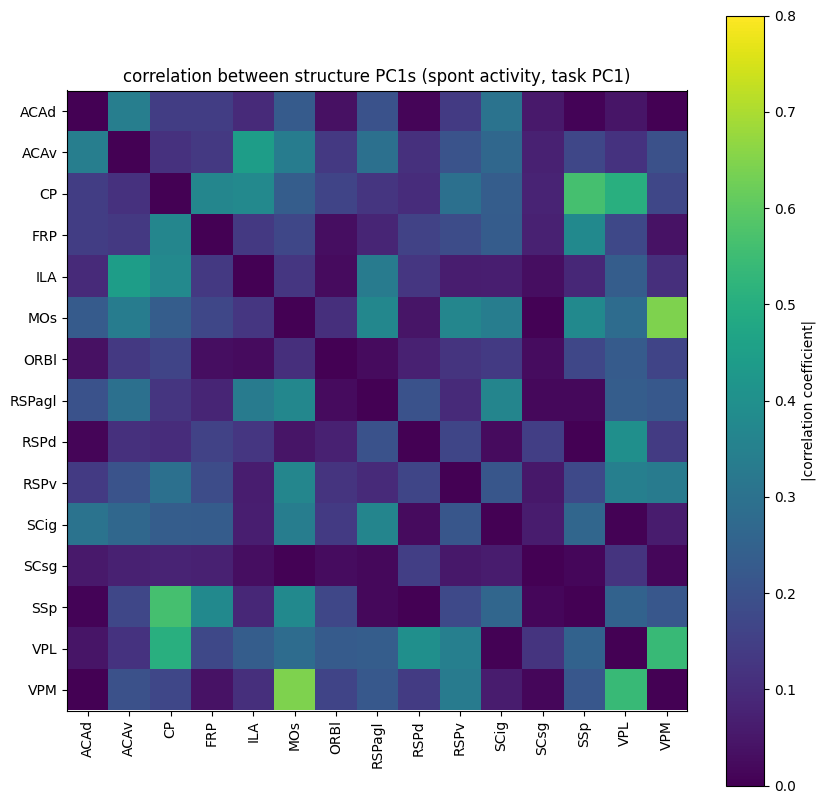

In [215]:
input_matrix=np.abs(spont_by_task_corr_all_pairs)

import matplotlib
masked_array = np.ma.array(input_matrix, mask=np.isnan(input_matrix))
cmap = matplotlib.cm.viridis
cmap.set_bad('grey',0.5)

fig,ax=plt.subplots(1,1,figsize=(10,10))

im=ax.imshow(input_matrix, cmap=cmap, vmin=0, vmax=0.8)

ax.set_xticks(np.arange(n_structures))
ax.set_xticklabels(structure_list, rotation=90)
ax.set_yticks(np.arange(n_structures))
ax.set_yticklabels(structure_list)
ax.set_title('correlation between structure PC1s (spont activity, task PC1)')

fig.colorbar(im, ax=ax, label='|correlation coefficient|')

### use LDA to find context dimension during task, project spontaneous onto it

In [83]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X_train = trial_da.data.reshape(trial_da.data.shape[0], -1).T
y_train = trials['is_vis_rewarded']

lda = LinearDiscriminantAnalysis(n_components=1) # Project to 1 dimension
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=1)

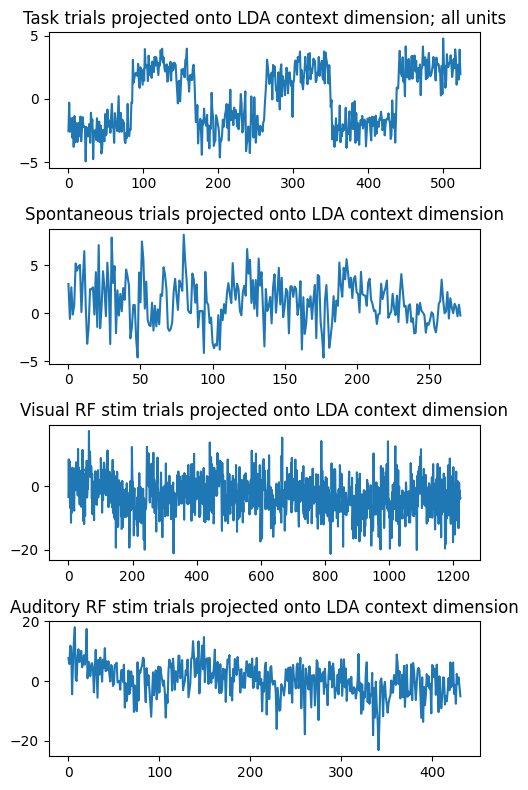

In [84]:
X_task = lda.transform(X_train)

X_spont = lda.transform(spont_trial_da.data.reshape(spont_trial_da.data.shape[0], -1).T)

X_vis_rf = lda.transform(vis_rf_stim_da.data.reshape(vis_rf_stim_da.data.shape[0], -1).T)

X_aud_rf = lda.transform(aud_rf_stim_da.data.reshape(aud_rf_stim_da.data.shape[0], -1).T)

fig,ax=plt.subplots(4,1,figsize=(5,8))
ax[0].plot(X_task)
ax[0].set_title('Task trials projected onto LDA context dimension; all units')
ax[1].plot(X_spont)
ax[1].set_title('Spontaneous trials projected onto LDA context dimension')
ax[2].plot(X_vis_rf)
ax[2].set_title('Visual RF stim trials projected onto LDA context dimension')
ax[3].plot(X_aud_rf)
ax[3].set_title('Auditory RF stim trials projected onto LDA context dimension')
fig.tight_layout()


In [85]:
#run LDA per structure, save projections of task and spont trials
structure_lda_results={
    'structure':[],
    'task_projection':[],
    'spont_projection':[],
    'task_projection_corrected':[],
    'spont_projection_corrected':[],
    'vis_rf_baseline_projection':[],
    'aud_rf_baseline_projection':[],
    'vis_rf_stim_projection':[],
    'aud_rf_stim_projection':[],
}

structures=units_filtered['structure'].unique()
for structure in structures:
    units_in_structure=units_filtered[units_filtered['structure']==structure]['unit_id'].unique()
    if len(units_in_structure)<10:
        continue
    
    structure_da=trial_da.sel(unit_id=units_in_structure)
    labels=trials['is_vis_rewarded']

    lda = LinearDiscriminantAnalysis(n_components=1) # Project to 1 dimension
    lda.fit(structure_da.data.reshape(structure_da.data.shape[0], -1).T, labels)
    task_projection = lda.transform(structure_da.data.reshape(structure_da.data.shape[0], -1).T).flatten()

    # project spontaneous activity onto context dimension
    spont_structure_da=spont_trial_da.sel(unit_id=units_in_structure)
    spont_projection = lda.transform(spont_structure_da.data.reshape(spont_structure_da.data.shape[0], -1).T).flatten()
    structure_lda_results['structure'].append(structure)
    structure_lda_results['task_projection'].append(task_projection)
    structure_lda_results['spont_projection'].append(spont_projection)

    # correct task projection by excluding instruction trials and removing blockwise mean
    block_idx=trials['block_index'].values
    instruction_trial_idx=trials['is_instruction'].values
    task_projection_corrected=task_projection.copy()
    task_projection_corrected[instruction_trial_idx]=np.nan #set instruction trials to nan
    for bidx in np.unique(block_idx):
        block_mean=np.mean(task_projection[block_idx==bidx])
        task_projection_corrected[block_idx==bidx]-=block_mean
    structure_lda_results['task_projection_corrected'].append(task_projection_corrected)

    # correct spont projection by removing epochwise mean
    epoch_idx=spont_trials_df['epoch_idx'].values
    spont_projection_corrected=spont_projection.copy()
    for eidx in np.unique(epoch_idx):
        epoch_mean=np.mean(spont_projection[epoch_idx==eidx])
        spont_projection_corrected[epoch_idx==eidx]-=epoch_mean
    structure_lda_results['spont_projection_corrected'].append(spont_projection_corrected)

    # project visual RF baseline trials onto context dimension
    vis_rf_structure_da=vis_rf_baseline_da.sel(unit_id=units_in_structure)
    vis_rf_projection = lda.transform(vis_rf_structure_da.data.reshape(vis_rf_structure_da.data.shape[0], -1).T).flatten()
    structure_lda_results['vis_rf_baseline_projection'].append(vis_rf_projection)

    # project auditory RF baseline trials onto context dimension
    aud_rf_structure_da=aud_rf_baseline_da.sel(unit_id=units_in_structure)
    aud_rf_projection = lda.transform(aud_rf_structure_da.data.reshape(aud_rf_structure_da.data.shape[0], -1).T).flatten()
    structure_lda_results['aud_rf_baseline_projection'].append(aud_rf_projection)

    # project visual RF stim trials onto context dimension
    vis_rf_stim_structure_da=vis_rf_stim_da.sel(unit_id=units_in_structure)
    vis_rf_stim_projection = lda.transform(vis_rf_stim_structure_da.data.reshape(vis_rf_stim_structure_da.data.shape[0], -1).T).flatten()
    structure_lda_results['vis_rf_stim_projection'].append(vis_rf_stim_projection)

    # project auditory RF stim trials onto context dimension
    aud_rf_stim_structure_da=aud_rf_stim_da.sel(unit_id=units_in_structure)
    aud_rf_stim_projection = lda.transform(aud_rf_stim_structure_da.data.reshape(aud_rf_stim_structure_da.data.shape[0], -1).T).flatten()
    structure_lda_results['aud_rf_stim_projection'].append(aud_rf_stim_projection)

structure_lda_results_df=pd.DataFrame(structure_lda_results)

In [87]:
structure_lda_results_df
# np.hstack(task_projection)
# np.hstack(spont_projection)
# spont_projection.flatten()

,structure,task_projection,spont_projection,task_projection_corrected,spont_projection_corrected,vis_rf_baseline_projection,aud_rf_baseline_projection,vis_rf_stim_projection,aud_rf_stim_projection
0,CP,"[-0.6903310143270247, 0.02211124614423779, -1....","[-0.2667773878540846, -0.49892825703615096, 1....","[nan, nan, nan, nan, nan, 0.45258715565118535,...","[-0.7256726384436931, -0.9578235076257595, 1.2...","[-4.069145620942432, 2.127910755657664, 1.2186...","[-0.28506315666640164, 0.8388260035563941, 1.1...","[-2.929290168326789, 1.0481957687461432, 3.183...","[2.047382372335659, 0.7077279723094315, 1.6716..."
1,SSp,"[-1.9065909979424043, -1.1791720701498225, -1....","[-6.229651505580335, -4.297578296375115, -1.46...","[nan, nan, nan, nan, nan, 0.17062506812516287,...","[-4.51947336048122, -2.587400151276, 0.2470098...","[-14.00613676118995, -1.8854433313381833, -0.0...","[-0.939365078039409, -1.1333033288350913, -0.8...","[-11.875910084584447, -0.4144013132984331, 6.8...","[0.1109768430770981, 2.73111560159662, 4.80422..."
2,ORBl,"[0.4911768796957743, 1.7199469978284125, -1.37...","[-10.542580664958123, -10.347979762081795, -7....","[nan, nan, nan, nan, nan, -0.8262178187114003,...","[-5.505152369161675, -5.3105514662853475, -2.7...","[-16.588845187225797, -15.204359940975829, -28...","[-11.408659823133474, -11.383446835014833, -22...","[-11.523218132889756, -22.643082741572037, -15...","[-19.3189474841991, -14.539354316239022, -22.8..."
3,FRP,"[-0.6104399931759752, -1.6779131728889698, 0.3...","[-0.684023717644063, -2.2669599897030124, -0.2...","[nan, nan, nan, nan, nan, -0.5743149487187345,...","[0.22110153839827384, -1.3618347336606755, 0.6...","[0.3788313671191538, 1.2495301879854508, 0.476...","[-2.6083266478990654, 0.8029637175341893, 3.83...","[5.3438781577807735, -11.989860906462967, 0.42...","[-0.8647550966045267, -8.906811279033757, -8.9..."
4,MOs,"[0.013018379163368492, 0.2601562364333995, -1....","[-0.8687987544320446, -0.49153590388095947, -1...","[nan, nan, nan, nan, nan, -0.16188347145186954...","[-0.7127372287268585, -0.3354743781757734, -1....","[-0.9530049167617378, -1.2596886985859541, -3....","[0.03415519763280937, 0.6612651593812507, -0.9...","[-3.014308132105863, 1.4334642580427555, -0.31...","[-1.9256017402565813, -2.97468051747598, 1.023..."
5,ILA,"[0.8327627008524627, 1.12198633828481, 0.23573...","[0.6822826785621615, 1.1607719791526068, 2.086...","[nan, nan, nan, nan, nan, -0.261378374192485, ...","[-0.21343186880486575, 0.2650574317855795, 1.1...","[2.40755263937465, 4.2418462338362914, 3.75334...","[0.8368609211944279, 2.3427994939396304, 6.392...","[0.1845601706899623, 3.248963127674299, 2.3217...","[1.3355719542439932, -1.9209810333508737, -3.7..."
6,ACAv,"[-1.494955967039799, -0.33729827015194225, -2....","[-3.010004879250608, -1.490748230105666, 2.364...","[nan, nan, nan, nan, nan, 0.6228350846086792, ...","[-3.5102361574979692, -1.9909795083530275, 1.8...","[-3.7148023515095754, -1.4948055259535382, -1....","[-1.8046420056804076, -3.8325376377271296, -1....","[-1.5808307002733741, -2.4385664843568784, 0.4...","[1.5905775784289107, -1.7061735956469346, 1.50..."
7,ACAd,"[0.7733212159583978, 0.6090109742495327, -2.23...","[1.9989020931425525, 0.5109241268596523, 2.381...","[nan, nan, nan, nan, nan, -1.5128213869174534,...","[0.4067197909780427, -1.0812581753048576, 0.78...","[0.04096007355215747, -0.620487617433498, -1.5...","[-0.715109797934743, 2.027941971573814, -2.408...","[1.186821666964272, -1.7692937169249088, -1.15...","[-0.9832386555307601, 0.09272569603601888, -3...."
8,SCig,"[1.8187519789443773, 0.8738440617337873, -0.73...","[-0.1835804567540671, 1.9357108697072285, -1.0...","[nan, nan, nan, nan, nan, 0.2185982951270482, ...","[-0.3650366102775068, 1.7542547161837887, -1.2...","[0.10215591647165834, 3.7505631348085346, 10.3...","[6.199105958838589, 3.315237347391154, 2.38120...","[-2.260791441084611, 7.307387362189407, -6.720...","[5.981761320800182, 7.383474014474188, 2.86440..."
9,

In [88]:
#get correlation between every pair of structures
structure_list=np.sort(structure_lda_results_df['structure'].unique())
n_structures=len(structure_list)

task_corr_all_pairs_lda=np.zeros((n_structures, n_structures))
spont_corr_all_pairs_lda=np.zeros((n_structures, n_structures))
task_corrected_corr_all_pairs_lda=np.zeros((n_structures, n_structures))
spont_corrected_corr_all_pairs_lda=np.zeros((n_structures, n_structures))
vis_rf_baseline_corr_all_pairs_lda=np.zeros((n_structures, n_structures))
aud_rf_baseline_corr_all_pairs_lda=np.zeros((n_structures, n_structures))
vis_rf_stim_corr_all_pairs_lda=np.zeros((n_structures, n_structures))
aud_rf_stim_corr_all_pairs_lda=np.zeros((n_structures, n_structures))

for i, structure_i in enumerate(structure_list):
    for j, structure_j in enumerate(structure_list):
        if i==j:
            task_corr_all_pairs_lda[i,j]=np.nan
            spont_corr_all_pairs_lda[i,j]=np.nan
            task_corrected_corr_all_pairs_lda[i,j]=np.nan
            continue
        structure_i_proj=structure_lda_results_df.query('structure==@structure_i')['task_projection'].values[0]
        structure_j_proj=structure_lda_results_df.query('structure==@structure_j')['task_projection'].values[0]
        r_task,p_task=stats.pearsonr(structure_i_proj, structure_j_proj)
        task_corr_all_pairs_lda[i,j]=r_task
        
        # compute spontaneous correlation
        structure_i_proj=structure_lda_results_df.query('structure==@structure_i')['spont_projection'].values[0]
        structure_j_proj=structure_lda_results_df.query('structure==@structure_j')['spont_projection'].values[0]
        r_spont,p_spont=stats.pearsonr(structure_i_proj, structure_j_proj)
        spont_corr_all_pairs_lda[i,j]=r_spont
        
        # compute task corrected correlation
        structure_i_proj=structure_lda_results_df.query('structure==@structure_i')['task_projection_corrected'].values[0]
        structure_j_proj=structure_lda_results_df.query('structure==@structure_j')['task_projection_corrected'].values[0]
        nan_idx=np.isnan(structure_i_proj) | np.isnan(structure_j_proj)
        r_task_corrected,p_task_corrected=stats.pearsonr(structure_i_proj[~nan_idx], structure_j_proj[~nan_idx])
        task_corrected_corr_all_pairs_lda[i,j]=r_task_corrected
       
        # compute spontaneous corrected correlation
        structure_i_proj=structure_lda_results_df.query('structure==@structure_i')['spont_projection_corrected'].values[0]
        structure_j_proj=structure_lda_results_df.query('structure==@structure_j')['spont_projection_corrected'].values[0]
        nan_idx=np.isnan(structure_i_proj) | np.isnan(structure_j_proj)
        r_spont_corrected,p_spont_corrected=stats.pearsonr(structure_i_proj[~nan_idx], structure_j_proj[~nan_idx])
        spont_corrected_corr_all_pairs_lda[i,j]=r_spont_corrected

        # compute visual RF correlation
        structure_i_proj=structure_lda_results_df.query('structure==@structure_i')['vis_rf_baseline_projection'].values[0]
        structure_j_proj=structure_lda_results_df.query('structure==@structure_j')['vis_rf_baseline_projection'].values[0]
        r_vis_rf,p_vis_rf=stats.pearsonr(structure_i_proj, structure_j_proj)
        vis_rf_baseline_corr_all_pairs_lda[i,j]=r_vis_rf

        # compute auditory RF correlation
        structure_i_proj=structure_lda_results_df.query('structure==@structure_i')['aud_rf_baseline_projection'].values[0]
        structure_j_proj=structure_lda_results_df.query('structure==@structure_j')['aud_rf_baseline_projection'].values[0]
        r_aud_rf,p_aud_rf=stats.pearsonr(structure_i_proj, structure_j_proj)
        aud_rf_baseline_corr_all_pairs_lda[i,j]=r_aud_rf

        # compute visual RF stim correlation
        structure_i_proj=structure_lda_results_df.query('structure==@structure_i')['vis_rf_stim_projection'].values[0]
        structure_j_proj=structure_lda_results_df.query('structure==@structure_j')['vis_rf_stim_projection'].values[0]
        r_vis_rf_stim,p_vis_rf_stim=stats.pearsonr(structure_i_proj, structure_j_proj)
        vis_rf_stim_corr_all_pairs_lda[i,j]=r_vis_rf_stim

        # compute auditory RF stim correlation
        structure_i_proj=structure_lda_results_df.query('structure==@structure_i')['aud_rf_stim_projection'].values[0]
        structure_j_proj=structure_lda_results_df.query('structure==@structure_j')['aud_rf_stim_projection'].values[0]
        r_aud_rf_stim,p_aud_rf_stim=stats.pearsonr(structure_i_proj, structure_j_proj)
        aud_rf_stim_corr_all_pairs_lda[i,j]=r_aud_rf_stim

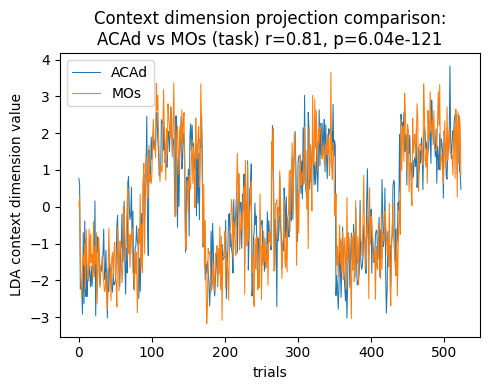

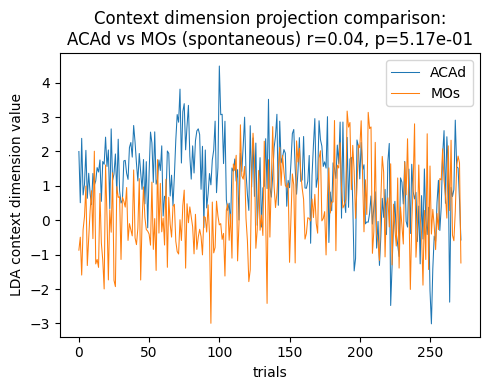

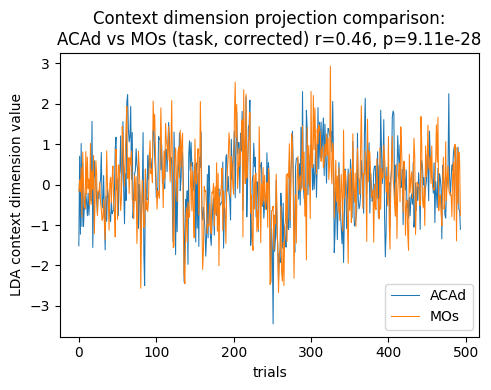

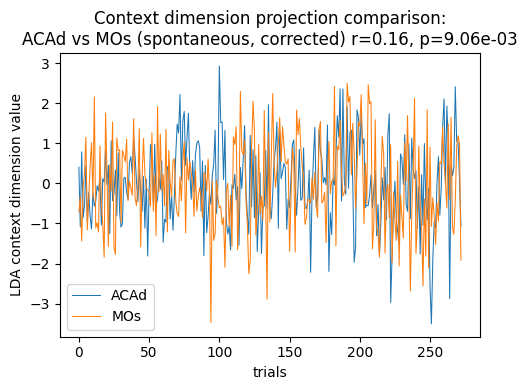

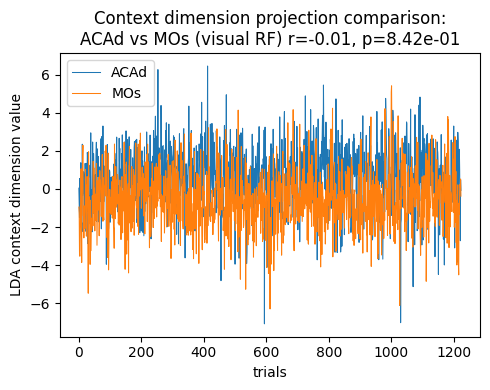

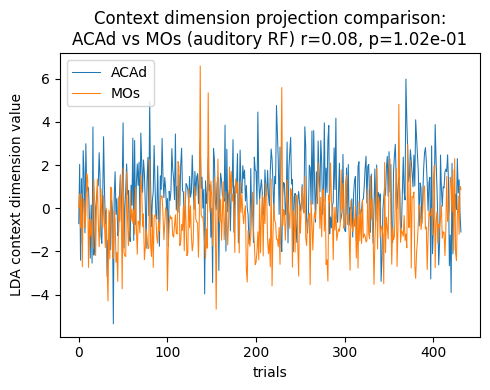

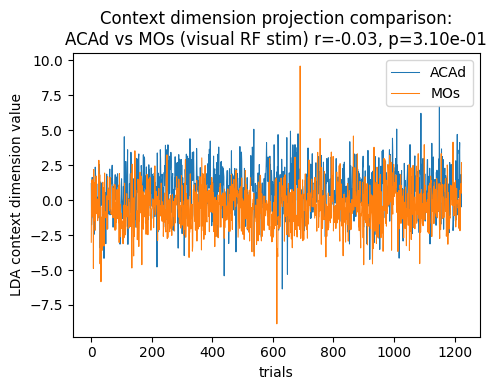

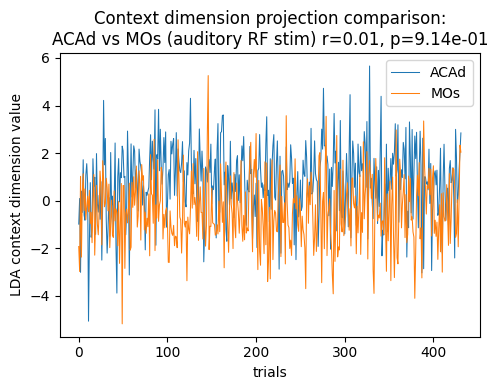

In [89]:
#plot example pair of areas
sel_structure_1='ACAd'
sel_structure_2='MOs'

fig,ax=plt.subplots(1,1,figsize=(5,4))
structure_1_task_proj=structure_lda_results_df.query('structure==@sel_structure_1')['task_projection'].values[0]
structure_2_task_proj=structure_lda_results_df.query('structure==@sel_structure_2')['task_projection'].values[0]
r,p=stats.pearsonr(structure_1_task_proj, structure_2_task_proj)
ax.plot(structure_1_task_proj, label=sel_structure_1, linewidth=0.75)
ax.plot(structure_2_task_proj, label=sel_structure_2, linewidth=0.75)
ax.set_title(f'Context dimension projection comparison:\n{sel_structure_1} vs {sel_structure_2} (task) r={r:.2f}, p={p:.2e}')
ax.set_xlabel('trials')
ax.set_ylabel('LDA context dimension value')
ax.legend()
fig.tight_layout()


fig,ax=plt.subplots(1,1,figsize=(5,4))
structure_1_spont_proj=structure_lda_results_df.query('structure==@sel_structure_1')['spont_projection'].values[0]
structure_2_spont_proj=structure_lda_results_df.query('structure==@sel_structure_2')['spont_projection'].values[0]
r,p=stats.pearsonr(structure_1_spont_proj, structure_2_spont_proj)
ax.plot(structure_1_spont_proj, label=sel_structure_1, linewidth=0.75)
ax.plot(structure_2_spont_proj, label=sel_structure_2, linewidth=0.75)
ax.set_title(f'Context dimension projection comparison:\n{sel_structure_1} vs {sel_structure_2} (spontaneous) r={r:.2f}, p={p:.2e}')
ax.set_xlabel('trials')
ax.set_ylabel('LDA context dimension value')
ax.legend()
fig.tight_layout()


fig,ax=plt.subplots(1,1,figsize=(5,4))
structure_1_spont_proj=structure_lda_results_df.query('structure==@sel_structure_1')['task_projection_corrected'].values[0]
structure_2_spont_proj=structure_lda_results_df.query('structure==@sel_structure_2')['task_projection_corrected'].values[0]
nan_idx=np.isnan(structure_1_spont_proj) | np.isnan(structure_2_spont_proj)
structure_1_spont_proj=structure_1_spont_proj[~nan_idx]
structure_2_spont_proj=structure_2_spont_proj[~nan_idx]
r,p=stats.pearsonr(structure_1_spont_proj, structure_2_spont_proj)
ax.plot(structure_1_spont_proj, label=sel_structure_1, linewidth=0.75)
ax.plot(structure_2_spont_proj, label=sel_structure_2, linewidth=0.75)
ax.set_title(f'Context dimension projection comparison:\n{sel_structure_1} vs {sel_structure_2} (task, corrected) r={r:.2f}, p={p:.2e}')
ax.set_xlabel('trials')
ax.set_ylabel('LDA context dimension value')
ax.legend()
fig.tight_layout()


fig,ax=plt.subplots(1,1,figsize=(5,4))
structure_1_spont_proj=structure_lda_results_df.query('structure==@sel_structure_1')['spont_projection_corrected'].values[0]
structure_2_spont_proj=structure_lda_results_df.query('structure==@sel_structure_2')['spont_projection_corrected'].values[0]
nan_idx=np.isnan(structure_1_spont_proj) | np.isnan(structure_2_spont_proj)
structure_1_spont_proj=structure_1_spont_proj[~nan_idx]
structure_2_spont_proj=structure_2_spont_proj[~nan_idx]
r,p=stats.pearsonr(structure_1_spont_proj, structure_2_spont_proj)
ax.plot(structure_1_spont_proj, label=sel_structure_1, linewidth=0.75)
ax.plot(structure_2_spont_proj, label=sel_structure_2, linewidth=0.75)
ax.set_title(f'Context dimension projection comparison:\n{sel_structure_1} vs {sel_structure_2} (spontaneous, corrected) r={r:.2f}, p={p:.2e}')
ax.set_xlabel('trials')
ax.set_ylabel('LDA context dimension value')
ax.legend()
fig.tight_layout()

fig,ax=plt.subplots(1,1,figsize=(5,4))
structure_1_vis_rf_proj=structure_lda_results_df.query('structure==@sel_structure_1')['vis_rf_baseline_projection'].values[0]
structure_2_vis_rf_proj=structure_lda_results_df.query('structure==@sel_structure_2')['vis_rf_baseline_projection'].values[0]
r,p=stats.pearsonr(structure_1_vis_rf_proj, structure_2_vis_rf_proj)
ax.plot(structure_1_vis_rf_proj, label=sel_structure_1, linewidth=0.75)
ax.plot(structure_2_vis_rf_proj, label=sel_structure_2, linewidth=0.75)
ax.set_title(f'Context dimension projection comparison:\n{sel_structure_1} vs {sel_structure_2} (visual RF) r={r:.2f}, p={p:.2e}')
ax.set_xlabel('trials')
ax.set_ylabel('LDA context dimension value')
ax.legend()
fig.tight_layout()

fig,ax=plt.subplots(1,1,figsize=(5,4))
structure_1_aud_rf_proj=structure_lda_results_df.query('structure==@sel_structure_1')['aud_rf_baseline_projection'].values[0]
structure_2_aud_rf_proj=structure_lda_results_df.query('structure==@sel_structure_2')['aud_rf_baseline_projection'].values[0]
r,p=stats.pearsonr(structure_1_aud_rf_proj, structure_2_aud_rf_proj)
ax.plot(structure_1_aud_rf_proj, label=sel_structure_1, linewidth=0.75)
ax.plot(structure_2_aud_rf_proj, label=sel_structure_2, linewidth=0.75)
ax.set_title(f'Context dimension projection comparison:\n{sel_structure_1} vs {sel_structure_2} (auditory RF) r={r:.2f}, p={p:.2e}')
ax.set_xlabel('trials')
ax.set_ylabel('LDA context dimension value')
ax.legend()
fig.tight_layout()

fig,ax=plt.subplots(1,1,figsize=(5,4))
structure_1_vis_rf_stim_proj=structure_lda_results_df.query('structure==@sel_structure_1')['vis_rf_stim_projection'].values[0]
structure_2_vis_rf_stim_proj=structure_lda_results_df.query('structure==@sel_structure_2')['vis_rf_stim_projection'].values[0]
r,p=stats.pearsonr(structure_1_vis_rf_stim_proj, structure_2_vis_rf_stim_proj)
ax.plot(structure_1_vis_rf_stim_proj, label=sel_structure_1, linewidth=0.75)
ax.plot(structure_2_vis_rf_stim_proj, label=sel_structure_2, linewidth=0.75)
ax.set_title(f'Context dimension projection comparison:\n{sel_structure_1} vs {sel_structure_2} (visual RF stim) r={r:.2f}, p={p:.2e}')
ax.set_xlabel('trials')
ax.set_ylabel('LDA context dimension value')
ax.legend()
fig.tight_layout()

fig,ax=plt.subplots(1,1,figsize=(5,4))
structure_1_aud_rf_stim_proj=structure_lda_results_df.query('structure==@sel_structure_1')['aud_rf_stim_projection'].values[0]
structure_2_aud_rf_stim_proj=structure_lda_results_df.query('structure==@sel_structure_2')['aud_rf_stim_projection'].values[0]
r,p=stats.pearsonr(structure_1_aud_rf_stim_proj, structure_2_aud_rf_stim_proj)
ax.plot(structure_1_aud_rf_stim_proj, label=sel_structure_1, linewidth=0.75)
ax.plot(structure_2_aud_rf_stim_proj, label=sel_structure_2, linewidth=0.75)
ax.set_title(f'Context dimension projection comparison:\n{sel_structure_1} vs {sel_structure_2} (auditory RF stim) r={r:.2f}, p={p:.2e}')
ax.set_xlabel('trials')
ax.set_ylabel('LDA context dimension value')
ax.legend()
fig.tight_layout()

In [90]:
r

0.005196993382736484

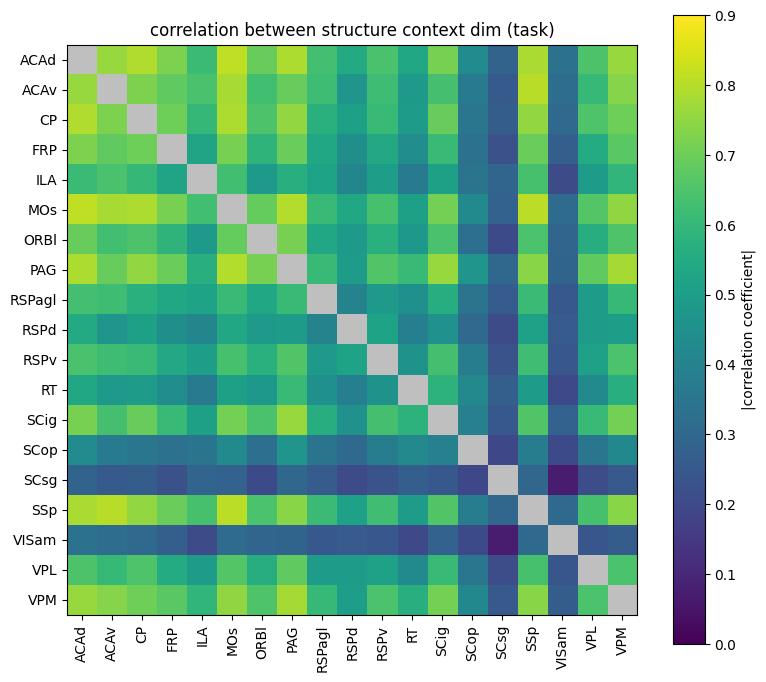

In [48]:
input_matrix=np.abs(task_corr_all_pairs_lda)

import matplotlib
masked_array = np.ma.array(input_matrix, mask=np.isnan(input_matrix))
cmap = matplotlib.cm.viridis
cmap.set_bad('grey',0.5)

fig,ax=plt.subplots(1,1,figsize=(8,7))

im=ax.imshow(input_matrix, cmap=cmap, vmin=0, vmax=0.9)

ax.set_xticks(np.arange(n_structures))
ax.set_xticklabels(structure_list, rotation=90)
ax.set_yticks(np.arange(n_structures))
ax.set_yticklabels(structure_list)
ax.set_title('correlation between structure context dim (task)')

fig.colorbar(im, ax=ax, label='|correlation coefficient|')
fig.tight_layout()

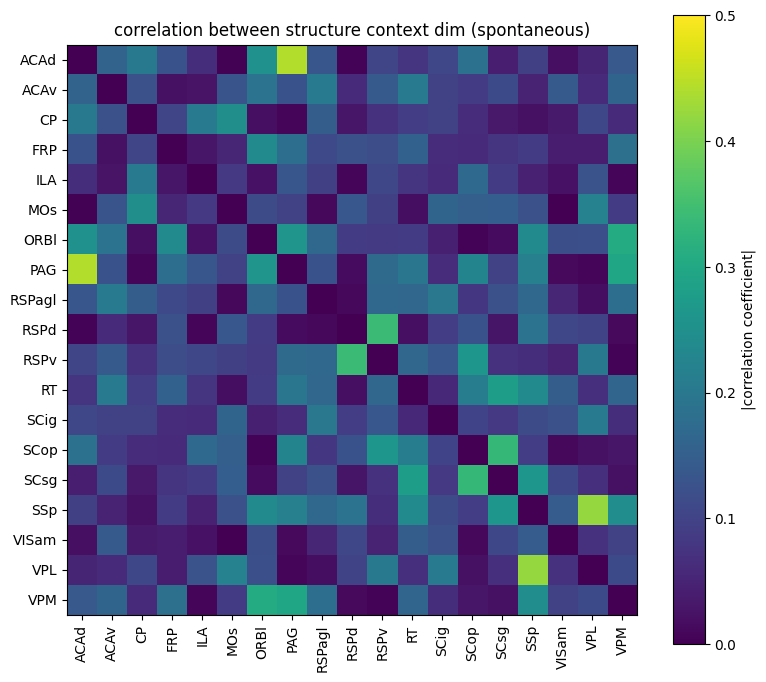

In [50]:
input_matrix=np.abs(spont_corrected_corr_all_pairs_lda)

import matplotlib
masked_array = np.ma.array(input_matrix, mask=np.isnan(input_matrix))
cmap = matplotlib.cm.viridis
cmap.set_bad('grey',0.5)

fig,ax=plt.subplots(1,1,figsize=(8,7))

im=ax.imshow(input_matrix, cmap=cmap, vmin=0, vmax=0.5)

ax.set_xticks(np.arange(n_structures))
ax.set_xticklabels(structure_list, rotation=90)
ax.set_yticks(np.arange(n_structures))
ax.set_yticklabels(structure_list)
ax.set_title('correlation between structure context dim (spontaneous)')

fig.colorbar(im, ax=ax, label='|correlation coefficient|')
fig.tight_layout()

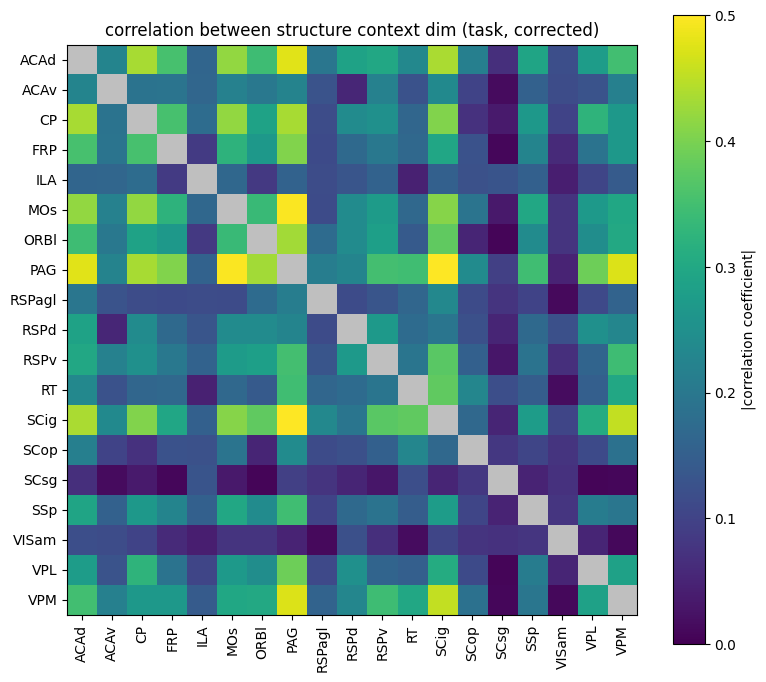

In [51]:
input_matrix=np.abs(task_corrected_corr_all_pairs_lda)

import matplotlib

masked_array = np.ma.array(input_matrix, mask=np.isnan(input_matrix))
cmap = matplotlib.cm.viridis
cmap.set_bad('grey',0.5)

fig,ax=plt.subplots(1,1,figsize=(8,7))

im=ax.imshow(input_matrix, cmap=cmap, vmin=0, vmax=0.5)

ax.set_xticks(np.arange(n_structures))
ax.set_xticklabels(structure_list, rotation=90)
ax.set_yticks(np.arange(n_structures))
ax.set_yticklabels(structure_list)
ax.set_title('correlation between structure context dim (task, corrected)')

fig.colorbar(im, ax=ax, label='|correlation coefficient|')
fig.tight_layout()

In [ ]:
custom_order=[
    'ACAd', 'ACAv', 'FRP', 'GU', 'ILA', 'MOs', 'ORBl', 'ORBm', 'ORBvl', 'PL',
    'SSp', 'SSs', 'VISal',
    'CP', 'LSr',
    'CA1', 
    'TTd'
]

custom_order_index=np.arange(len(custom_order),dtype=int)

custom_order_pd = pd.DataFrame({
    'structure': custom_order,
    'index': custom_order_index
})

custom_order_pd

In [ ]:
#cluster the correlation matrix
from sklearn.cluster import SpectralCoclustering
from sklearn.cluster import SpectralBiclustering
from sklearn.metrics import consensus_score

corr_matrix=task_corrected_corr_all_pairs_lda.copy()

cluster_corr_matrix=np.abs(task_corrected_corr_all_pairs_lda.copy())

cluster_corr_matrix[np.isnan(cluster_corr_matrix)]=np.nanmean(cluster_corr_matrix)

data=cluster_corr_matrix.copy()

model = SpectralBiclustering(n_clusters=2, method="log", random_state=0,)# svd_method='arpack', n_init=25)
# model = SpectralCoclustering(n_clusters=2, random_state=0)
model.fit(data)

#switch cluster order?
switch_cluster_order=None
if switch_cluster_order is not None:
    model.row_labels_ = np.array([switch_cluster_order[label] for label in model.row_labels_])
    model.column_labels_ = np.array([switch_cluster_order[label] for label in model.column_labels_])

custom_order_pd_copy=custom_order_pd.copy()

custom_incl_structures=True

if custom_incl_structures:
    custom_order_pd_copy['cluster'] = model.row_labels_
    custom_order_pd_copy.sort_values(by=['cluster', 'index'], inplace=True)
    sort_idx=custom_order_pd_copy.index.values
    fit_data = corr_matrix[sort_idx]
    fit_data = fit_data[:, sort_idx]
    
else:
    sort_idx = np.argsort(model.row_labels_)
    fit_data = corr_matrix[sort_idx]
    fit_data = fit_data[:, sort_idx]

In [ ]:
# custom_order_pd_copy['structure']

In [ ]:
structure_labels=structure_list[sort_idx]

masked_array = np.ma.array(fit_data, mask=np.isnan(fit_data))
cmap = matplotlib.cm.viridis
cmap.set_bad('grey',0.5)

fig,ax=plt.subplots(1,1,figsize=(5,4))
im=ax.imshow(np.abs(masked_array), aspect='auto', cmap=cmap, vmin=0.0, vmax=0.5, extent=[-0.5,len(structure_labels)-0.5,len(structure_labels)-0.5,-0.5])
ax.set_xticks(np.arange(len(structure_labels)), np.array(structure_labels), rotation=90)
ax.set_yticks(np.arange(len(structure_labels)), np.array(structure_labels))

row_labels = model.row_labels_
sorted_row_labels = row_labels[sort_idx]
cluster_borders = np.where(np.diff(sorted_row_labels) != 0)[0] + 0.5

for xx in cluster_borders:
    ax.axvline(x=xx, color='black', linestyle='-', linewidth=2)
    ax.axhline(y=xx, color='black', linestyle='-', linewidth=2)

#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('mean Pearson r between\ncontext dimension projections')

# ax.set_title(f'Spectral biclustering of ')

In [ ]:
#save figure
savepath=r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-12-01-plots_for_DR_PAC\LDA_task_corrected_context_projection_corr_example_session_0.0-0.5.png'
fig.savefig(savepath, bbox_inches='tight', dpi=300,
            transparent=True, format='png', pad_inches=0.1)

In [ ]:
#plot spontaneous correlation matrix with same ordering
sorted_spont_data = spont_corr_all_pairs_lda[sort_idx]
sorted_spont_data = sorted_spont_data[:, sort_idx]
structure_labels=structure_list[sort_idx]

masked_array = np.ma.array(sorted_spont_data, mask=np.isnan(sorted_spont_data))
cmap = matplotlib.cm.viridis
cmap.set_bad('grey',0.5)

fig,ax=plt.subplots(1,1,figsize=(5,4))
im=ax.imshow(np.abs(masked_array), aspect='auto', cmap=cmap, vmin=0.0, vmax=0.5, extent=[-0.5,len(structure_labels)-0.5,len(structure_labels)-0.5,-0.5])
ax.set_xticks(np.arange(len(structure_labels)), np.array(structure_labels), rotation=90)
ax.set_yticks(np.arange(len(structure_labels)), np.array(structure_labels))

row_labels = model.row_labels_
sorted_row_labels = row_labels[sort_idx]
cluster_borders = np.where(np.diff(sorted_row_labels) != 0)[0] + 0.5

for xx in cluster_borders:
    ax.axvline(x=xx, color='black', linestyle='-', linewidth=2)
    ax.axhline(y=xx, color='black', linestyle='-', linewidth=2)

#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('mean Pearson r between\ncontext dimension projections')

In [ ]:
#save figure
savepath=r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-12-01-plots_for_DR_PAC\LDA_spont_context_projection_corr_example_session_0.0-0.5.png'
fig.savefig(savepath, bbox_inches='tight', dpi=300,
            transparent=True, format='png', pad_inches=0.1)

In [ ]:
spont_custom_order=[
    'ACAd', 'FRP', 'GU', 'MOs', 'ORBl',  'PL',
    'SSp', 'SSs',
    'CP', 

    'ACAv','ILA','ORBm', 'ORBvl','VISal',
    'LSr',
    'CA1',
    'TTd'

]

spont_custom_order_index=np.arange(len(spont_custom_order),dtype=int)

spont_custom_order_pd = pd.DataFrame({
    'structure': spont_custom_order,
    'index': spont_custom_order_index
})

In [ ]:
#sort spontaneous matrix by custom order


masked_array = np.ma.array(sorted_spont_data, mask=np.isnan(sorted_spont_data))
cmap = matplotlib.cm.viridis
cmap.set_bad('grey',0.5)

fig,ax=plt.subplots(1,1,figsize=(5,4))
im=ax.imshow(np.abs(masked_array), aspect='auto', cmap=cmap, vmin=0.0, vmax=0.5, extent=[-0.5,len(structure_labels)-0.5,len(structure_labels)-0.5,-0.5])
ax.set_xticks(np.arange(len(structure_labels)), np.array(structure_labels), rotation=90)
ax.set_yticks(np.arange(len(structure_labels)), np.array(structure_labels))

row_labels = model.row_labels_
sorted_row_labels = row_labels[sort_idx]
cluster_borders = np.where(np.diff(sorted_row_labels) != 0)[0] + 0.5

for xx in cluster_borders:
    ax.axvline(x=xx, color='black', linestyle='-', linewidth=2)
    ax.axhline(y=xx, color='black', linestyle='-', linewidth=2)

#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('mean Pearson r between\ncontext dimension projections')

In [77]:
#project smaller timebin activity onto various LDA defined dimensions

#make data array

units_filtered = units.query(
    'presence_ratio>=0.7 and \
    isi_violations_ratio<=0.5 and \
    amplitude_cutoff<=0.1 and \
    activity_drift<=0.1 and \
    firing_rate>=0.5 and \
    ~structure.isna() and ~location.isna()'
    ).sort_values(['electrode_group_name', 'peak_channel', 'unit_id'])

time_before = 1.5
time_after = 6.5
binsize = 0.100
trial_da_small = spike_utils.make_neuron_time_trials_tensor(units_filtered, trials, time_before, time_after, binsize)


In [106]:
structure='MOs'
units_in_structure=units_filtered[units_filtered['structure']==structure]['unit_id'].unique()
structure_da=trial_da_small.sel(unit_id=units_in_structure)
context_labels=trials['is_vis_rewarded']
context_time_window=(-0.5,0)
context_lda = LinearDiscriminantAnalysis(n_components=1) # Project to 1 dimension
context_lda.fit(structure_da.sel(time=slice(*context_time_window)).mean(dim='time').data.T, context_labels)

lick_labels=trials.query('~is_hit and is_target')['is_response']
lick_time_window=(0.3,0.6)
lick_lda = LinearDiscriminantAnalysis(n_components=1) # Project to 1 dimension
lick_lda.fit(structure_da.sel(time=slice(*lick_time_window),trials=trials.query('~is_hit and is_target').index).mean(dim='time').data.T, lick_labels)

reward_labels=trials.query('is_response')['is_rewarded']
reward_time_window=(0.3,1.0)
reward_lda = LinearDiscriminantAnalysis(n_components=1) # Project to 1 dimension
reward_lda.fit(structure_da.sel(time=slice(*reward_time_window),trials=trials.query('is_response').index).mean(dim='time').data.T, reward_labels)

vis_target_labels=trials.query('is_vis_target')['is_vis_target']
vis_baseline_labels=np.full(len(vis_target_labels),fill_value=False)
vis_stim_time_window=(0,0.1)
vis_baseline_time_window=(-0.1,0)
vis_labels=np.concatenate([vis_baseline_labels, vis_target_labels])
vis_stim_data=np.concatenate([structure_da.sel(time=slice(*vis_baseline_time_window),trials=trials.query('is_vis_target').index).mean(dim='time').data,
                             structure_da.sel(time=slice(*vis_stim_time_window),trials=trials.query('is_vis_target').index).mean(dim='time').data], axis=1)
vis_lda = LinearDiscriminantAnalysis(n_components=1) # Project to 1 dimension
vis_lda.fit(vis_stim_data.T, vis_labels)

aud_target_labels=trials.query('is_aud_target')['is_aud_target']
aud_baseline_labels=np.full(len(aud_target_labels),fill_value=False)
aud_stim_time_window=(0,0.1)
aud_baseline_time_window=(-0.1,0)
aud_labels=np.concatenate([aud_baseline_labels, aud_target_labels])
aud_stim_data=np.concatenate([structure_da.sel(time=slice(*aud_baseline_time_window),trials=trials.query('is_aud_target').index).mean(dim='time').data,
                             structure_da.sel(time=slice(*aud_stim_time_window),trials=trials.query('is_aud_target').index).mean(dim='time').data], axis=1)
aud_lda = LinearDiscriminantAnalysis(n_components=1) # Project to 1 dimension
aud_lda.fit(aud_stim_data.T, aud_labels)

vis_vs_aud_target_labels=trials.query('is_target')['is_vis_target']
stim_time_window=(0,0.1)
vis_vs_aud_lda = LinearDiscriminantAnalysis(n_components=1) # Project to 1 dimension
vis_vs_aud_lda.fit(structure_da.sel(time=slice(*stim_time_window),trials=trials.query('is_target').index).mean(dim='time').data.T, vis_vs_aud_target_labels)

LinearDiscriminantAnalysis(n_components=1)

In [107]:
#correlation between the various weight vectors
lda_weight_vectors={
    'context': context_lda.coef_.flatten(),
    'lick': lick_lda.coef_.flatten(),
    'reward': reward_lda.coef_.flatten(),
    'vis_target': vis_lda.coef_.flatten(),
    'aud_target': aud_lda.coef_.flatten(),
    # 'vis_vs_aud_target': vis_vs_aud_lda.coef_.flatten(),
}

lda_weight_vectors_df=pd.DataFrame(lda_weight_vectors)
lda_weight_vectors_df.corr()

,context,lick,reward,vis_target,aud_target
context,1.000000,0.008101,0.054974,0.037397,0.150798
lick,0.008101,1.000000,-0.062704,-0.018799,0.206271
reward,0.054974,-0.062704,1.000000,0.167265,0.058517
vis_target,0.037397,-0.018799,0.167265,1.000000,0.087004
aud_target,0.150798,0.206271,0.058517,0.087004,1.000000


In [94]:
#plot correlation matrix
input_matrix=lda_weight_vectors_df.corr().values
input_matrix[input_matrix==1.0]=np.nan  #set diagonal to nan
import matplotlib
masked_array = np.ma.array(input_matrix, mask=np.isnan(input_matrix))
cmap = matplotlib.cm.bwr
cmap.set_bad('grey',0.5)
fig,ax=plt.subplots(1,1,figsize=(5,4))
im=ax.imshow(input_matrix, cmap=cmap, vmin=-0.3, vmax=0.3)
ax.set_xticks(np.arange(len(lda_weight_vectors_df.columns)), lda_weight_vectors_df.columns, rotation=90)
ax.set_yticks(np.arange(len(lda_weight_vectors_df.columns)), lda_weight_vectors_df.columns)
ax.set_title(f'LDA weight vector correlations - {structure}')
fig.colorbar(im, ax=ax, label='correlation coefficient')

ValueError: assignment destination is read-only

In [ ]:
# structure_da
# structure_da.sel(time=slice(*vis_baseline_time_window)).data
# vis_labels
# vis_stim_data.shape
# structure_da.sel(time=slice(*vis_baseline_time_window),trials=trials.query('is_vis_target').index).mean(dim='time').data.shape


In [101]:
task_context_projection = np.full(structure_da.mean(dim='unit_id').data.shape, np.nan)
for t_idx, t in enumerate(structure_da['time'].values):
    # if t < context_time_window[0] or t > context_time_window[1]:
    timepoint_data = structure_da.sel(time=t).data.T
    projection = context_lda.transform(timepoint_data).flatten()
    task_context_projection[t_idx] = projection

task_lick_projection = np.full(structure_da.mean(dim='unit_id').data.shape, np.nan)
for t_idx, t in enumerate(structure_da['time'].values):
    # if t < lick_time_window[0] or t > lick_time_window[1]:
    timepoint_data = structure_da.sel(time=t).data.T
    projection = lick_lda.transform(timepoint_data).flatten()
    task_lick_projection[t_idx] = projection

task_vis_projection = np.full(structure_da.mean(dim='unit_id').data.shape, np.nan)
for t_idx, t in enumerate(structure_da['time'].values):
    # if t < vis_stim_time_window[0] or t > vis_stim_time_window[1]:
    timepoint_data = structure_da.sel(time=t).data.T
    projection = vis_lda.transform(timepoint_data).flatten()
    task_vis_projection[t_idx] = projection

task_aud_projection = np.full(structure_da.mean(dim='unit_id').data.shape, np.nan)
for t_idx, t in enumerate(structure_da['time'].values):
    # if t < aud_stim_time_window[0] or t > aud_stim_time_window[1]:
    timepoint_data = structure_da.sel(time=t).data.T
    projection = aud_lda.transform(timepoint_data).flatten()
    task_aud_projection[t_idx] = projection

task_vis_vs_aud_projection = np.full(structure_da.mean(dim='unit_id').data.shape, np.nan)
for t_idx, t in enumerate(structure_da['time'].values):
    # if t < stim_time_window[0] or t > stim_time_window[1]:
    timepoint_data = structure_da.sel(time=t).data.T
    projection = vis_vs_aud_lda.transform(timepoint_data).flatten()
    task_vis_vs_aud_projection[t_idx] = projection

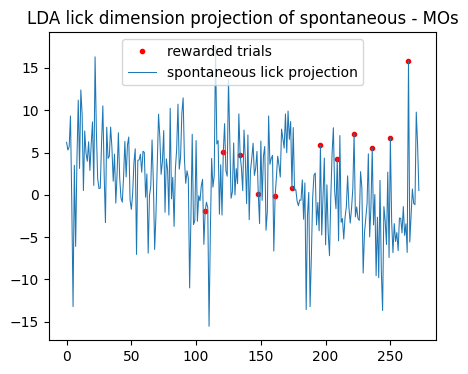

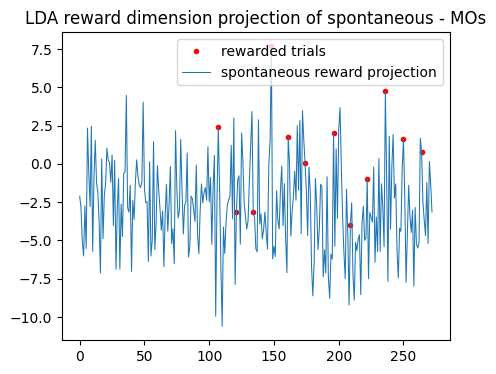

In [108]:
# project spontaneous, rf activity onto these dimensions

# project spontaneous onto lick dimension
units_in_structure=units_filtered[units_filtered['structure']==structure]['unit_id'].unique()
spont_structure_da=spont_trial_da.sel(unit_id=units_in_structure)
spont_lick_projection = lick_lda.transform(spont_structure_da.data.reshape(spont_structure_da.data.shape[0], -1).T).flatten()

rewarded_trial_idx=spont_trials_df.query('is_rewarded').index

fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.plot(rewarded_trial_idx, spont_lick_projection[rewarded_trial_idx], 'ro', label='rewarded trials', markersize=3)
ax.plot(spont_lick_projection, label='spontaneous lick projection', linewidth=0.75)
ax.set_title(f'LDA lick dimension projection of spontaneous - {structure}')
ax.legend()

#project spontaneous onto reward dimension
spont_reward_projection = reward_lda.transform(spont_structure_da.data.reshape(spont_structure_da.data.shape[0], -1).T).flatten()
fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.plot(rewarded_trial_idx, spont_reward_projection[rewarded_trial_idx], 'ro', label='rewarded trials', markersize=3)
ax.plot(spont_reward_projection, label='spontaneous reward projection', linewidth=0.75)
ax.set_title(f'LDA reward dimension projection of spontaneous - {structure}')
ax.legend()

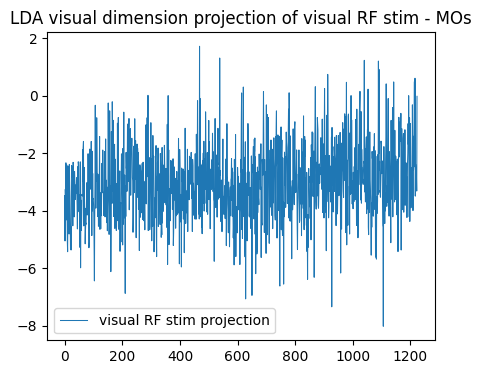

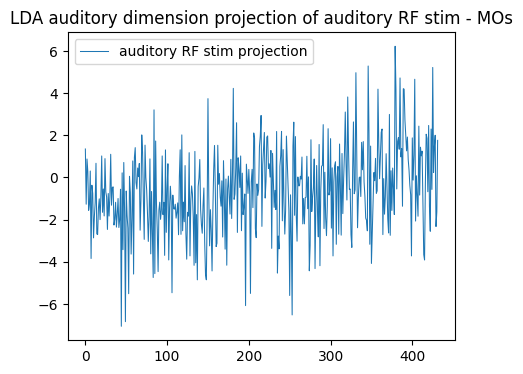

In [105]:
#project vis RF stim onto vis target dimension
vis_rf_stim_structure_da=vis_rf_stim_da.sel(unit_id=units_in_structure)
vis_rf_stim_projection = vis_lda.transform(vis_rf_stim_structure_da.data.reshape(vis_rf_stim_structure_da.data.shape[0], -1).T).flatten()
fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.plot(vis_rf_stim_projection, label='visual RF stim projection', linewidth=0.75)
ax.set_title(f'LDA visual dimension projection of visual RF stim - {structure}')
ax.legend()

#project aud RF stim onto aud target dimension
aud_rf_stim_structure_da=aud_rf_stim_da.sel(unit_id=units_in_structure)
aud_rf_stim_projection = aud_lda.transform(aud_rf_stim_structure_da.data.reshape(aud_rf_stim_structure_da.data.shape[0], -1).T).flatten()
fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.plot(aud_rf_stim_projection, label='auditory RF stim projection', linewidth=0.75)
ax.set_title(f'LDA auditory dimension projection of auditory RF stim - {structure}')
ax.legend()

In [ ]:
# get time bins across whole session


# project activity onto these dimensions


# correlate between areas in different epochs



In [ ]:
task_context_projection.shape

In [ ]:
vis_context_vis_stim_hit_trials = trials.query('is_vis_rewarded and is_vis_target and is_response')['trial_index'].values
vis_context_aud_stim_fa_trials = trials.query('is_vis_rewarded and is_aud_target and is_response')['trial_index'].values
vis_context_aud_stim_cr_trials = trials.query('is_vis_rewarded and is_aud_target and ~is_response')['trial_index'].values

aud_context_aud_stim_hit_trials = trials.query('~is_vis_rewarded and is_aud_target and is_response')['trial_index'].values
aud_context_vis_stim_fa_trials = trials.query('~is_vis_rewarded and is_vis_target and is_response')['trial_index'].values
aud_context_vis_stim_cr_trials = trials.query('~is_vis_rewarded and is_vis_target and ~is_response')['trial_index'].values

In [ ]:
#get mean and sem for each condition
def get_mean_sem(projection, trial_indices):
    selected_projection = projection[:, trial_indices]
    mean_projection = np.nanmean(selected_projection, axis=1)
    sem_projection = stats.sem(selected_projection, axis=1, nan_policy='omit')
    return mean_projection, sem_projection

In [ ]:
#plot context projections for each condition

mean_vis_context_vis_stim_hit, sem_vis_context_vis_stim_hit = get_mean_sem(task_context_projection, vis_context_vis_stim_hit_trials)
mean_vis_context_aud_stim_fa, sem_vis_context_aud_stim_fa = get_mean_sem(task_context_projection, vis_context_aud_stim_fa_trials)
mean_vis_context_aud_stim_cr, sem_vis_context_aud_stim_cr = get_mean_sem(task_context_projection, vis_context_aud_stim_cr_trials)
mean_aud_context_aud_stim_hit, sem_aud_context_aud_stim_hit = get_mean_sem(task_context_projection, aud_context_aud_stim_hit_trials)
mean_aud_context_vis_stim_fa, sem_aud_context_vis_stim_fa = get_mean_sem(task_context_projection, aud_context_vis_stim_fa_trials)
mean_aud_context_vis_stim_cr, sem_aud_context_vis_stim_cr = get_mean_sem(task_context_projection, aud_context_vis_stim_cr_trials)

fig,ax=plt.subplots(1,1,figsize=(6,4))
time_values=structure_da['time'].values
ax.plot(time_values, mean_vis_context_vis_stim_hit, label='Vis context, Vis stim, Hit', color='green')
ax.fill_between(time_values, mean_vis_context_vis_stim_hit - sem_vis_context_vis_stim_hit, mean_vis_context_vis_stim_hit + sem_vis_context_vis_stim_hit, color='green', alpha=0.3)
ax.plot(time_values, mean_aud_context_vis_stim_fa, label='Aud context, Vis stim, FA', color='red')
ax.fill_between(time_values, mean_aud_context_vis_stim_fa - sem_aud_context_vis_stim_fa, mean_aud_context_vis_stim_fa + sem_aud_context_vis_stim_fa, color='red', alpha=0.3)
ax.plot(time_values, mean_aud_context_vis_stim_cr, label='Aud context, Vis stim, CR', color='blue')
ax.fill_between(time_values, mean_aud_context_vis_stim_cr - sem_aud_context_vis_stim_cr, mean_aud_context_vis_stim_cr + sem_aud_context_vis_stim_cr, color='blue', alpha=0.3)
ax.axvline(0, color='k', linestyle='--', linewidth=0.75)
ax.axhline(0, color='k', linestyle='--', linewidth=0.75)
ax.set_title(f'Context dimension projection - {structure}\nVis stimulus trials')
ax.legend()

fig,ax=plt.subplots(1,1,figsize=(6,4))
time_values=structure_da['time'].values
ax.plot(time_values, mean_aud_context_aud_stim_hit, label='Aud context, Aud stim, Hit', color='green')
ax.fill_between(time_values, mean_aud_context_aud_stim_hit - sem_aud_context_aud_stim_hit, mean_aud_context_aud_stim_hit + sem_aud_context_aud_stim_hit, color='green', alpha=0.3)
ax.plot(time_values, mean_vis_context_aud_stim_fa, label='Vis context, Aud stim, FA', color='red')
ax.fill_between(time_values, mean_vis_context_aud_stim_fa - sem_vis_context_aud_stim_fa, mean_vis_context_aud_stim_fa + sem_vis_context_aud_stim_fa, color='red', alpha=0.3)
ax.plot(time_values, mean_vis_context_aud_stim_cr, label='Vis context, Aud stim, CR', color='blue')
ax.fill_between(time_values, mean_vis_context_aud_stim_cr - sem_vis_context_aud_stim_cr, mean_vis_context_aud_stim_cr + sem_vis_context_aud_stim_cr, color='blue', alpha=0.3)
ax.axvline(0, color='k', linestyle='--', linewidth=0.75)
ax.axhline(0, color='k', linestyle='--', linewidth=0.75)
ax.set_title(f'Context dimension projection - {structure}\nAuditory stimulus trials')
ax.legend()

In [ ]:
#plot lick projections for each condition
mean_vis_context_vis_stim_hit_lick, sem_vis_context_vis_stim_hit_lick = get_mean_sem(task_lick_projection, vis_context_vis_stim_hit_trials)
mean_vis_context_aud_stim_fa_lick, sem_vis_context_aud_stim_fa_lick = get_mean_sem(task_lick_projection, vis_context_aud_stim_fa_trials)
mean_vis_context_aud_stim_cr_lick, sem_vis_context_aud_stim_cr_lick = get_mean_sem(task_lick_projection, vis_context_aud_stim_cr_trials)
mean_aud_context_aud_stim_hit_lick, sem_aud_context_aud_stim_hit_lick = get_mean_sem(task_lick_projection, aud_context_aud_stim_hit_trials)
mean_aud_context_vis_stim_fa_lick, sem_aud_context_vis_stim_fa_lick = get_mean_sem(task_lick_projection, aud_context_vis_stim_fa_trials)
mean_aud_context_vis_stim_cr_lick, sem_aud_context_vis_stim_cr_lick = get_mean_sem(task_lick_projection, aud_context_vis_stim_cr_trials)

fig,ax=plt.subplots(1,1,figsize=(6,4))
time_values=structure_da['time'].values
ax.plot(time_values, mean_vis_context_vis_stim_hit_lick, label='Vis context, Vis stim, Hit', color='green')
ax.fill_between(time_values, mean_vis_context_vis_stim_hit_lick - sem_vis_context_vis_stim_hit_lick, mean_vis_context_vis_stim_hit_lick + sem_vis_context_vis_stim_hit_lick, color='green', alpha=0.3)
ax.plot(time_values, mean_aud_context_vis_stim_fa_lick, label='Aud context, Vis stim, FA', color='red')
ax.fill_between(time_values, mean_aud_context_vis_stim_fa_lick - sem_aud_context_vis_stim_fa_lick, mean_aud_context_vis_stim_fa_lick + sem_aud_context_vis_stim_fa_lick, color='red', alpha=0.3)
ax.plot(time_values, mean_aud_context_vis_stim_cr_lick, label='Aud context, Vis stim, CR', color='blue')
ax.fill_between(time_values, mean_aud_context_vis_stim_cr_lick - sem_aud_context_vis_stim_cr_lick, mean_aud_context_vis_stim_cr_lick + sem_aud_context_vis_stim_cr_lick, color='blue', alpha=0.3)
ax.axvline(0, color='k', linestyle='--', linewidth=0.75)
ax.axhline(0, color='k', linestyle='--', linewidth=0.75)
ax.set_title(f'Lick dimension projection - {structure}\nVis stimulus trials')
ax.legend()

fig,ax=plt.subplots(1,1,figsize=(6,4))
time_values=structure_da['time'].values
ax.plot(time_values, mean_aud_context_aud_stim_hit_lick, label='Aud context, Aud stim, Hit', color='green')
ax.fill_between(time_values, mean_aud_context_aud_stim_hit_lick - sem_aud_context_aud_stim_hit_lick, mean_aud_context_aud_stim_hit_lick + sem_aud_context_aud_stim_hit_lick, color='green', alpha=0.3)
ax.plot(time_values, mean_vis_context_aud_stim_fa_lick, label='Vis context, Aud stim, FA', color='red')
ax.fill_between(time_values, mean_vis_context_aud_stim_fa_lick - sem_vis_context_aud_stim_fa_lick, mean_vis_context_aud_stim_fa_lick + sem_vis_context_aud_stim_fa_lick, color='red', alpha=0.3)
ax.plot(time_values, mean_vis_context_aud_stim_cr_lick, label='Vis context, Aud stim, CR', color='blue')
ax.fill_between(time_values, mean_vis_context_aud_stim_cr_lick - sem_vis_context_aud_stim_cr_lick, mean_vis_context_aud_stim_cr_lick + sem_vis_context_aud_stim_cr_lick, color='blue', alpha=0.3)
ax.axvline(0, color='k', linestyle='--', linewidth=0.75)
ax.axhline(0, color='k', linestyle='--', linewidth=0.75)
ax.set_title(f'Lick dimension projection - {structure}\nAuditory stimulus trials')
ax.legend()

In [ ]:
#plot vis stimulus projections for each condition
mean_vis_context_vis_stim_hit_vis, sem_vis_context_vis_stim_hit_vis = get_mean_sem(task_vis_projection, vis_context_vis_stim_hit_trials)
mean_vis_context_aud_stim_fa_vis, sem_vis_context_aud_stim_fa_vis = get_mean_sem(task_vis_projection, vis_context_aud_stim_fa_trials)
mean_vis_context_aud_stim_cr_vis, sem_vis_context_aud_stim_cr_vis = get_mean_sem(task_vis_projection, vis_context_aud_stim_cr_trials)
mean_aud_context_aud_stim_hit_vis, sem_aud_context_aud_stim_hit_vis = get_mean_sem(task_vis_projection, aud_context_aud_stim_hit_trials)
mean_aud_context_vis_stim_fa_vis, sem_aud_context_vis_stim_fa_vis = get_mean_sem(task_vis_projection, aud_context_vis_stim_fa_trials)
mean_aud_context_vis_stim_cr_vis, sem_aud_context_vis_stim_cr_vis = get_mean_sem(task_vis_projection, aud_context_vis_stim_cr_trials)

fig,ax=plt.subplots(1,1,figsize=(6,4))
time_values=structure_da['time'].values
ax.plot(time_values, mean_vis_context_vis_stim_hit_vis, label='Vis context, Vis stim, Hit', color='green')
ax.fill_between(time_values, mean_vis_context_vis_stim_hit_vis - sem_vis_context_vis_stim_hit_vis, mean_vis_context_vis_stim_hit_vis + sem_vis_context_vis_stim_hit_vis, color='green', alpha=0.3)
ax.plot(time_values, mean_aud_context_vis_stim_fa_vis, label='Aud context, Vis stim, FA', color='red')
ax.fill_between(time_values, mean_aud_context_vis_stim_fa_vis - sem_aud_context_vis_stim_fa_vis, mean_aud_context_vis_stim_fa_vis + sem_aud_context_vis_stim_fa_vis, color='red', alpha=0.3)
ax.plot(time_values, mean_aud_context_vis_stim_cr_vis, label='Aud context, Vis stim, CR', color='blue')
ax.fill_between(time_values, mean_aud_context_vis_stim_cr_vis - sem_aud_context_vis_stim_cr_vis, mean_aud_context_vis_stim_cr_vis + sem_aud_context_vis_stim_cr_vis, color='blue', alpha=0.3)
ax.axvline(0, color='k', linestyle='--', linewidth=0.75)
ax.axhline(0, color='k', linestyle='--', linewidth=0.75)
ax.set_title(f'Visual stimulus dimension projection - {structure}\nVis stimulus trials')
ax.legend()

fig,ax=plt.subplots(1,1,figsize=(6,4))
time_values=structure_da['time'].values
ax.plot(time_values, mean_aud_context_aud_stim_hit_vis, label='Aud context, Aud stim, Hit', color='green')
ax.fill_between(time_values, mean_aud_context_aud_stim_hit_vis - sem_aud_context_aud_stim_hit_vis, mean_aud_context_aud_stim_hit_vis + sem_aud_context_aud_stim_hit_vis, color='green', alpha=0.3)
ax.plot(time_values, mean_vis_context_aud_stim_fa_vis, label='Vis context, Aud stim, FA', color='red')
ax.fill_between(time_values, mean_vis_context_aud_stim_fa_vis - sem_vis_context_aud_stim_fa_vis, mean_vis_context_aud_stim_fa_vis + sem_vis_context_aud_stim_fa_vis, color='red', alpha=0.3)
ax.plot(time_values, mean_vis_context_aud_stim_cr_vis, label='Vis context, Aud stim, CR', color='blue')
ax.fill_between(time_values, mean_vis_context_aud_stim_cr_vis - sem_vis_context_aud_stim_cr_vis, mean_vis_context_aud_stim_cr_vis + sem_vis_context_aud_stim_cr_vis, color='blue', alpha=0.3)
ax.axvline(0, color='k', linestyle='--', linewidth=0.75)
ax.axhline(0, color='k', linestyle='--', linewidth=0.75)
ax.set_title(f'Visual stimulus dimension projection - {structure}\nAuditory stimulus trials')
ax.legend()

In [ ]:
#plot aud stimulus projections for each condition
mean_vis_context_vis_stim_hit_aud, sem_vis_context_vis_stim_hit_aud = get_mean_sem(task_aud_projection, vis_context_vis_stim_hit_trials)
mean_vis_context_aud_stim_fa_aud, sem_vis_context_aud_stim_fa_aud = get_mean_sem(task_aud_projection, vis_context_aud_stim_fa_trials)
mean_vis_context_aud_stim_cr_aud, sem_vis_context_aud_stim_cr_aud = get_mean_sem(task_aud_projection, vis_context_aud_stim_cr_trials)
mean_aud_context_aud_stim_hit_aud, sem_aud_context_aud_stim_hit_aud = get_mean_sem(task_aud_projection, aud_context_aud_stim_hit_trials)
mean_aud_context_vis_stim_fa_aud, sem_aud_context_vis_stim_fa_aud = get_mean_sem(task_aud_projection, aud_context_vis_stim_fa_trials)
mean_aud_context_vis_stim_cr_aud, sem_aud_context_vis_stim_cr_aud = get_mean_sem(task_aud_projection, aud_context_vis_stim_cr_trials)

fig,ax=plt.subplots(1,1,figsize=(6,4))
time_values=structure_da['time'].values
ax.plot(time_values, mean_vis_context_vis_stim_hit_aud, label='Vis context, Vis stim, Hit', color='green')
ax.fill_between(time_values, mean_vis_context_vis_stim_hit_aud - sem_vis_context_vis_stim_hit_aud, mean_vis_context_vis_stim_hit_aud + sem_vis_context_vis_stim_hit_aud, color='green', alpha=0.3)
ax.plot(time_values, mean_aud_context_vis_stim_fa_aud, label='Aud context, Vis stim, FA', color='red')
ax.fill_between(time_values, mean_aud_context_vis_stim_fa_aud - sem_aud_context_vis_stim_fa_aud, mean_aud_context_vis_stim_fa_aud + sem_aud_context_vis_stim_fa_aud, color='red', alpha=0.3)
ax.plot(time_values, mean_aud_context_vis_stim_cr_aud, label='Aud context, Vis stim, CR', color='blue')
ax.fill_between(time_values, mean_aud_context_vis_stim_cr_aud - sem_aud_context_vis_stim_cr_aud, mean_aud_context_vis_stim_cr_aud + sem_aud_context_vis_stim_cr_aud, color='blue', alpha=0.3)
ax.axvline(0, color='k', linestyle='--', linewidth=0.75)
ax.axhline(0, color='k', linestyle='--', linewidth=0.75)
ax.set_title(f'Auditory stimulus dimension projection - {structure}\nVis stimulus trials')
ax.legend()

fig,ax=plt.subplots(1,1,figsize=(6,4))
time_values=structure_da['time'].values
ax.plot(time_values, mean_aud_context_aud_stim_hit_aud, label='Aud context, Aud stim, Hit', color='green')
ax.fill_between(time_values, mean_aud_context_aud_stim_hit_aud - sem_aud_context_aud_stim_hit_aud, mean_aud_context_aud_stim_hit_aud + sem_aud_context_aud_stim_hit_aud, color='green', alpha=0.3)
ax.plot(time_values, mean_vis_context_aud_stim_fa_aud, label='Vis context, Aud stim, FA', color='red')
ax.fill_between(time_values, mean_vis_context_aud_stim_fa_aud - sem_vis_context_aud_stim_fa_aud, mean_vis_context_aud_stim_fa_aud + sem_vis_context_aud_stim_fa_aud, color='red', alpha=0.3)
ax.plot(time_values, mean_vis_context_aud_stim_cr_aud, label='Vis context, Aud stim, CR', color='blue')
ax.fill_between(time_values, mean_vis_context_aud_stim_cr_aud - sem_vis_context_aud_stim_cr_aud, mean_vis_context_aud_stim_cr_aud + sem_vis_context_aud_stim_cr_aud, color='blue', alpha=0.3)
ax.axvline(0, color='k', linestyle='--', linewidth=0.75)
ax.axhline(0, color='k', linestyle='--', linewidth=0.75)
ax.set_title(f'Auditory stimulus dimension projection - {structure}\nAuditory stimulus trials')
ax.legend()

In [ ]:
#plot vis vs aud stimulus projections for each condition
mean_vis_context_vis_stim_hit_vis_vs_aud, sem_vis_context_vis_stim_hit_vis_vs_aud = get_mean_sem(task_vis_vs_aud_projection, vis_context_vis_stim_hit_trials)
mean_vis_context_aud_stim_fa_vis_vs_aud, sem_vis_context_aud_stim_fa_vis_vs_aud = get_mean_sem(task_vis_vs_aud_projection, vis_context_aud_stim_fa_trials)
mean_vis_context_aud_stim_cr_vis_vs_aud, sem_vis_context_aud_stim_cr_vis_vs_aud = get_mean_sem(task_vis_vs_aud_projection, vis_context_aud_stim_cr_trials)
mean_aud_context_aud_stim_hit_vis_vs_aud, sem_aud_context_aud_stim_hit_vis_vs_aud = get_mean_sem(task_vis_vs_aud_projection, aud_context_aud_stim_hit_trials)
mean_aud_context_vis_stim_fa_vis_vs_aud, sem_aud_context_vis_stim_fa_vis_vs_aud = get_mean_sem(task_vis_vs_aud_projection, aud_context_vis_stim_fa_trials)
mean_aud_context_vis_stim_cr_vis_vs_aud, sem_aud_context_vis_stim_cr_vis_vs_aud = get_mean_sem(task_vis_vs_aud_projection, aud_context_vis_stim_cr_trials)

fig,ax=plt.subplots(1,1,figsize=(6,4))
time_values=structure_da['time'].values
ax.plot(time_values, mean_vis_context_vis_stim_hit_vis_vs_aud, label='Vis context, Vis stim, Hit', color='green')
ax.fill_between(time_values, mean_vis_context_vis_stim_hit_vis_vs_aud - sem_vis_context_vis_stim_hit_vis_vs_aud, mean_vis_context_vis_stim_hit_vis_vs_aud + sem_vis_context_vis_stim_hit_vis_vs_aud, color='green', alpha=0.3)
ax.plot(time_values, mean_aud_context_vis_stim_fa_vis_vs_aud, label='Aud context, Vis stim, FA', color='red')
ax.fill_between(time_values, mean_aud_context_vis_stim_fa_vis_vs_aud - sem_aud_context_vis_stim_fa_vis_vs_aud, mean_aud_context_vis_stim_fa_vis_vs_aud + sem_aud_context_vis_stim_fa_vis_vs_aud, color='red', alpha=0.3)
ax.plot(time_values, mean_aud_context_vis_stim_cr_vis_vs_aud, label='Aud context, Vis stim, CR', color='blue')
ax.fill_between(time_values, mean_aud_context_vis_stim_cr_vis_vs_aud - sem_aud_context_vis_stim_cr_vis_vs_aud, mean_aud_context_vis_stim_cr_vis_vs_aud + sem_aud_context_vis_stim_cr_vis_vs_aud, color='blue', alpha=0.3)
ax.axvline(0, color='k', linestyle='--', linewidth=0.75)
ax.axhline(0, color='k', linestyle='--', linewidth=0.75)
ax.set_title(f'Vis vs Aud stimulus dimension projection - {structure}\nVis stimulus trials')
ax.legend()

fig,ax=plt.subplots(1,1,figsize=(6,4))
time_values=structure_da['time'].values
ax.plot(time_values, mean_aud_context_aud_stim_hit_vis_vs_aud, label='Aud context, Aud stim, Hit', color='green')
ax.fill_between(time_values, mean_aud_context_aud_stim_hit_vis_vs_aud - sem_aud_context_aud_stim_hit_vis_vs_aud, mean_aud_context_aud_stim_hit_vis_vs_aud + sem_aud_context_aud_stim_hit_vis_vs_aud, color='green', alpha=0.3)
ax.plot(time_values, mean_vis_context_aud_stim_fa_vis_vs_aud, label='Vis context, Aud stim, FA', color='red')
ax.fill_between(time_values, mean_vis_context_aud_stim_fa_vis_vs_aud - sem_vis_context_aud_stim_fa_vis_vs_aud, mean_vis_context_aud_stim_fa_vis_vs_aud + sem_vis_context_aud_stim_fa_vis_vs_aud, color='red', alpha=0.3)
ax.plot(time_values, mean_vis_context_aud_stim_cr_vis_vs_aud, label='Vis context, Aud stim, CR', color='blue')
ax.fill_between(time_values, mean_vis_context_aud_stim_cr_vis_vs_aud - sem_vis_context_aud_stim_cr_vis_vs_aud, mean_vis_context_aud_stim_cr_vis_vs_aud + sem_vis_context_aud_stim_cr_vis_vs_aud, color='blue', alpha=0.3)
ax.axvline(0, color='k', linestyle='--', linewidth=0.75)
ax.axhline(0, color='k', linestyle='--', linewidth=0.75)
ax.set_title(f'Vis vs Aud stimulus dimension projection - {structure}\nAuditory stimulus trials')
ax.legend()

In [ ]:
mean_vis_context_vis_stim_hit

In [ ]:
#run LDA per structure, save projections of task and spont trials
structure_lda_projections={
    'structure':[],
    'task_context_projection':[],
    'task_lick_projection':[],
    'task_vis_target_projection':[],
    'task_aud_target_projection':[],
}

structures=units_filtered['structure'].unique()
for structure in structures:
    units_in_structure=units_filtered[units_filtered['structure']==structure]['unit_id'].unique()
    if len(units_in_structure)<10:
        continue
    
    structure_da=trial_da_small.sel(unit_id=units_in_structure)
    context_labels=trials['is_vis_rewarded']
    context_time_window=(-0.5,0)

    context_lda = LinearDiscriminantAnalysis(n_components=1) # Project to 1 dimension
    context_lda.fit(structure_da.sel(time=slice(*context_time_window)).data.T, context_labels)

    task_context_projection = context_lda.transform(structure_da.data.T)

    lick_labels=trials['is_response']

### single unit correlations

In [ ]:
corr_all_pairs=np.corrcoef(trial_da.data.reshape(trial_da.data.shape[0], -1))

In [ ]:
corr_all_pairs.shape

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
im=ax.imshow(corr_all_pairs, cmap='bwr', vmin=-0.2, vmax=0.2)

#add structure boundaries and labels
structure_boundaries = []
structure_labels = []
current_structure = units_filtered.iloc[0]['structure']
for i, row in units_filtered.reset_index().iterrows():
    if row['structure'] != current_structure:
        structure_boundaries.append(i)
        structure_labels.append(current_structure)
        current_structure = row['structure']

#add labels to plot
for boundary in structure_boundaries:
    ax.axhline(boundary, color='k', linestyle='-',linewidth=0.5)
    ax.axvline(boundary, color='k', linestyle='-',linewidth=0.5)
midpoints = []
start = 0
for boundary in structure_boundaries + [len(units_filtered)]:
    midpoints.append((start + boundary) / 2)
    start = boundary
for midpoint, label in zip(midpoints, structure_labels + [current_structure]):
    ax.text(midpoint, -5, label, ha='center', va='bottom', rotation=90)
    ax.text(-5, midpoint, label, ha='right', va='center')

ax.set_yticks([])

#colorbar
cbar = fig.colorbar(im, ax=ax,)
cbar.set_label('Correlation coefficient')


In [ ]:
spont_corr_all_pairs=np.corrcoef(spont_trial_da.data.reshape(spont_trial_da.data.shape[0], -1))

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.imshow(spont_corr_all_pairs, cmap='bwr', vmin=-0.3, vmax=0.3)

#add structure boundaries and labels
structure_boundaries = []
structure_labels = []
current_structure = units_filtered.iloc[0]['structure']
for i, row in units_filtered.reset_index().iterrows():
    if row['structure'] != current_structure:
        structure_boundaries.append(i)
        structure_labels.append(current_structure)
        current_structure = row['structure']

#add labels to plot
for boundary in structure_boundaries:
    ax.axhline(boundary, color='k', linestyle='-',linewidth=0.5)
    ax.axvline(boundary, color='k', linestyle='-',linewidth=0.5)
midpoints = []
start = 0
for boundary in structure_boundaries + [len(units_filtered)]:
    midpoints.append((start + boundary) / 2)
    start = boundary
for midpoint, label in zip(midpoints, structure_labels + [current_structure]):
    ax.text(midpoint, -5, label, ha='center', va='bottom', rotation=90)
    ax.text(-5, midpoint, label, ha='right', va='center')

ax.set_yticks([])

#colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Correlation coefficient')

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
im=ax.imshow(corr_all_pairs-spont_corr_all_pairs, cmap='bwr', vmin=-0.3, vmax=0.3)

#add structure boundaries and labels
structure_boundaries = []
structure_labels = []
current_structure = units_filtered.iloc[0]['structure']
for i, row in units_filtered.reset_index().iterrows():
    if row['structure'] != current_structure:
        structure_boundaries.append(i)
        structure_labels.append(current_structure)
        current_structure = row['structure']

#add labels to plot
for boundary in structure_boundaries:
    ax.axhline(boundary, color='k', linestyle='-',linewidth=0.5)
    ax.axvline(boundary, color='k', linestyle='-',linewidth=0.5)
midpoints = []
start = 0
for boundary in structure_boundaries + [len(units_filtered)]:
    midpoints.append((start + boundary) / 2)
    start = boundary
for midpoint, label in zip(midpoints, structure_labels + [current_structure]):
    ax.text(midpoint, -5, label, ha='center', va='bottom', rotation=90)
    ax.text(-5, midpoint, label, ha='right', va='center')

ax.set_yticks([])

#colorbar
cbar = fig.colorbar(im, ax=ax,)
cbar.set_label('change in correlation coefficient (task-spontaneous)')


In [ ]:
xbins=np.arange(-0.5,0.51,0.01)

fig,ax=plt.subplots(1,1)
ax.axvline(0, color='k', linestyle='--', linewidth=0.75)
# ax.hist(corr_all_pairs.flatten(), bins=xbins, alpha=0.5, label='Task')
# ax.hist(spont_corr_all_pairs.flatten(), bins=xbins, alpha=0.5, label='Spontaneous')
ax.hist((corr_all_pairs-spont_corr_all_pairs).flatten(), bins=xbins, alpha=0.5, label='Task')
ax.set_xlabel('Correlation coefficient')
ax.set_ylabel('count')
ax.legend()

In [ ]:
np.mean((corr_all_pairs-spont_corr_all_pairs).flatten())